tutorial link: 
https://www.kaggle.com/nicapotato/guided-numeric-and-text-exploration-e-commerce

# Data Dictionary:

    Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.

    Age: Positive Integer variable of the reviewers age.

    Title: String variable for the title of the review.

    Review Text: String variable for the review body.

    Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

    Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

    Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.

    Division Name: Categorical name of the product high level division.

    Department Name: Categorical name of the product department name.

    Class Name: Categorical name of the product class name.

# Set Environment

In [1]:
##general
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image 

##visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS 

##set plot theme
sns. set_palette([ "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",])

##Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

##Modeling
import scipy.special
#!pip3 install scipy==1.2 --upgrade
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec



##Warnings
import warnings
warnings.filterwarnings('ignore')

##Code Explanation and Reasoning: 

These packages are separated in four categories: General, Visualization, Pre-Processing, and Modeling.

The General category includes the basic data manipulation tools for scientific computation (numpy), dataframes (pandas), Natural Language Processing (NLTK), path directory manipulation (os), and image saving (PIL).

The Visualization section enables the creation of simple graphics (matplotlib, seaborn), as well as wordcloud's text frequency visualization.

The Pre-Processing section extracts more specialized modules from the NLTK package such as tokenizers and stemmers to enable the preparation of text data for mathematical analysis.

The Modeling section includes nltk’s sentiment analysis module, which can determine the mood of text, NLTK’s N-grams, and gensim.models’s word2vec. It also includes statsmodels.api which offers an array of linear models.

In [2]:
##read and peak at Data
df = pd.read_csv("/Users/warren/Desktop/UTD/19 Summer break/project/Women's E-Commerce Clothing Reviews/Womens Clothing E-Commerce Reviews.csv"
)

df.drop(df.columns[0], inplace=True, axis=1)

####df 執行 drop method, df.columns回傳colname


## delete missing value of these variables
for i in ['Review Text','Division Name','Department Name', 'Class Name']:
    df=df[df[i].notnull()]
    
####邏輯： df[i].notnull() 是一個idx


##total missing value
print('Missing Values : {}'.format(df.isnull().sum().sum()))

##data dimension
print('data dimension:{}'.format(*df.shape))

##create new variables
#word length
df['Word Count']= df['Review Text'].str.split().apply(len)
####str.split() 會切分完整的“字”而非字母

#character length
df['Character Count']= df['Review Text'].apply(len)
#bollean for positive and negative review
df['Label']=0
df.loc[df.Rating>=3, ['Label']]=1
#### python 不能直接index[row,col], 需要透過.loc叫出idx之後才能

Missing Values : 2966
data dimension:22628


##Code Explanation and Reasoning: 
After reading in the data, a binary variable is created to better to generalize rating into "good" and "bad" reviews. It is important to note that rating is a personal level judgement. Perhaps the "Recommended" feature may provide more insight into the value of the product, since customers are putting their reputation on the line to state whether they think its worth wearing. This social dimension is paramount when it comes to this product. Indeed, I found that many reviews would declare the social response and experience they had while wearing the clothing item.

Next, the dataset is purged of observation where the review text is unavailable. This was done because the review is the heart of this analysis. In fact, there are additional missing values, which I will leave for now, since they may provide usable extra information.

In [3]:
df.sample(6)

Clothing ID  Age                      Title  \
13809         1095   32           Very flattering!   
13104         1078   27                 Exquisite!   
16889          831   28                        NaN   
21641         1009   25              Not worth it.   
9264          1086   44  Hem difficult to judge...   
18380          933   39                        NaN   

                                             Review Text  Rating  \
13809  I'm going to be straight out... this dress is ...       5   
13104  This is one of those rare garments that is act...       5   
16889  I'm worried about the quality of the shirt. it...       2   
21641  While i love the fabric and the pattern, this ...       1   
9264   At 5'4" i typically order petite clothing...i ...       4   
18380  Great sweater. long and warm, but not too thic...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
13809                1                        0  General Petite   
13104                1                        3         General   
16889                0                        0         General   
21641                0                        5         General   
9264                 1                        7         General   
18380                1                        0  General Petite   

      Department Name Class Name  Word Count  Character Count  Label  
13809         Dresses    Dresses          81              385      1  
13104         Dresses    Dresses          95              500      1  
16889            Tops    Blouses          47              239      0  
21641         Bottoms     Skirts          98              502      0  
9264          Dresses    Dresses          96              500      1  
18380            Tops   Sweaters          20              103      1

# Univariate Distribution

In [4]:
print('Dataframe dimension: {} rows, {} columns'. format(*df.shape))
#### * 號表示把物件拆開，放到{}格子裡，所以這裏有兩個物件，需要兩個{}, format 表示把值填到{}裡




Dataframe dimension: 22628 rows, 13 columns


In [5]:
## Extracting Missing Count and Unique Count by Column
unique_count= []

for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

pd.DataFrame(unique_count, columns=['column', 'unique','missing']).set_index('column').T

##info: title has many missing value; the high unique value of clothing id and class name tell us that we need to do some non- visual exploratory method on it.

column   Clothing ID  Age  Title  Review Text  Rating  Recommended IND  \
unique          1172   77  13984        22621       5                2   
missing            0    0   2966            0       0                0   

column   Positive Feedback Count  Division Name  Department Name  Class Name  \
unique                        82              3                6          20   
missing                        0              0                0           0   

column   Word Count  Character Count  Label  
unique          114              497      2  
missing           0                0      0

In [6]:
df.describe().T.drop('count', axis=1)
####axis=1 表示by col


mean         std   min    25%    50%     75%  \
Clothing ID              919.695908  201.683804   1.0  861.0  936.0  1078.0   
Age                       43.282880   12.328176  18.0   34.0   41.0    52.0   
Rating                     4.183092    1.115911   1.0    4.0    5.0     5.0   
Recommended IND            0.818764    0.385222   0.0    1.0    1.0     1.0   
Positive Feedback Count    2.631784    5.787520   0.0    0.0    1.0     3.0   
Word Count                60.211950   28.533053   2.0   36.0   59.0    88.0   
Character Count          308.761534  143.934126   9.0  186.0  302.0   459.0   
Label                      0.895263    0.306222   0.0    1.0    1.0     1.0   

                            max  
Clothing ID              1205.0  
Age                        99.0  
Rating                      5.0  
Recommended IND             1.0  
Positive Feedback Count   122.0  
Word Count                115.0  
Character Count           508.0  
Label                       1.0

In [7]:
df[['Title','Division Name','Class Name','Department Name']].describe(include=["O"]).T.drop('count', axis=1)
##'O'表示exclude numeric data


unique       top   freq
Title            13983  Love it!    136
Division Name        3   General  13365
Class Name          20   Dresses   6145
Department Name      6      Tops  10048

## Age and positive feedback distribution

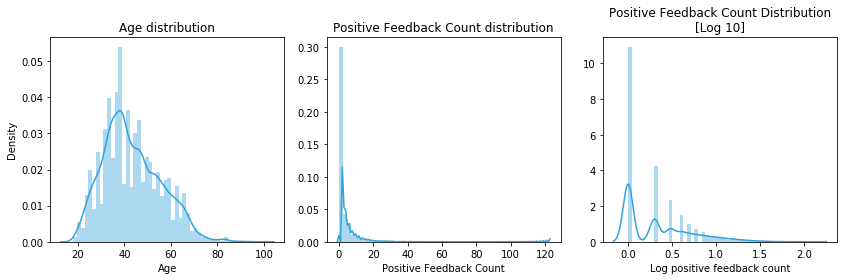

In [8]:


#set up canvas
f,ax=plt.subplots(1,3,figsize=(12,4),sharey=False)
##plt.subplots 產生兩個物件, 第一個是圖，第二個是idx， 1表示row, 3表示col
#Age
sns.distplot(df.Age,ax=ax[0])
####利用ax=idx，來指定在畫布上要顯示的位置

ax[0].set_title('Age distribution')
ax[0].set_ylabel('Density')

#Positive feedback
sns.distplot(df['Positive Feedback Count'],ax=ax[1])
ax[1].set_title("Positive Feedback Count distribution")
##info: too skewed, we need to log it

#
sns.distplot(np.log10((df['Positive Feedback Count'][df['Positive Feedback Count'].notnull()]+1)),ax=ax[2])
####先slice col, 再slice row一次，所有會出現兩個[][], 注意這裡如果不+1會跳error 因為log(0)是無理數
ax[2].set_title('Positive Feedback Count Distribution\n[Log 10]')
ax[2].set_xlabel('Log positive feedback count')

plt.tight_layout()
plt.show()


Code Explanation: 
Using seaborn, a simple variable frequency bar/density plot is created. In the log positive feedback count plot, I had to add 0.0001 to all values so that the logarithm of previously zero values can be taken. Matplotlib's subplots function is employed through assign each plot the AX argument.

### info
distribution of Age:
the customers' age centers on 35-45, a interesting feature since young people should be more comfortable with on-line purchasing.

distribution of positive feedback:
It is a exponential (Pareto) distribution, probably because the phenomenon called Cumulative-Advantage Effect / Matthew Effect or the Pareto Principle, due to lack of attention of most customers.



#### Cumulative-Advantage Effect / Matthew Effect: 
Coined by Robert K. Merton in 1968, this states that once a social agent gains a small advantage over other agents, that advantage will compound over time into an increasingly larger advantage. Here is the passage from the New Testament:

"For to everyone who has will more be given, and he will have abundance; but from him who has not, even what he has will be taken away." Matthew 25:29

This tendency effects any system with a positive feedback loop, which compounds. This effect turns out to be quite common among competing agents, and what we end up with, is a the Pareto Distribution.

Pareto Distribution: 
Also known as the 80/20 rule. Often used to describe the distribution of wealth, 20% of the population hold 80% of the wealth. I wonder how accurate this rule of thumb applies to the distribution of Positive Feedback.

## Percentage Accumulation from "Most Wealthy"


### Define function (Gini coefficeint, Inequatity test)

In [9]:
def percentage_accumulation(series, percentage):
    return(series.sort_values(ascending=False)
          [:round(series.shape[0]*(percentage/100))]
          .sum()/series.sum()
           *100
          )

####回傳一個前XX% 消費者花費占總花費的百分比

def gini(list_of_values):
    sorted_list= sorted(list_of_values)
    height, area=0,0
    for value in sorted_list:
        height+=value
        area+=height-value/2.
    fair_area=height*len(list_of_values)/2.
    return(fair_area-area)/fair_area  
# Gini Coefficient- Inequality Score
# Source: https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/



##gini and inequatity are used for different aspect of same question


#### The Gini Coefficient is one way to measure how evenly the income (or wealth) is distributed throughout a country.
reference: https://www.intmath.com/blog/mathematics/the-gini-coefficient-of-wealth-distribution-4187

### Generic Matplotlib Plot of whole df

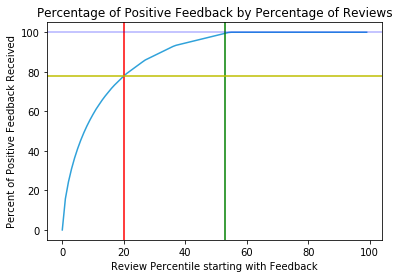

In [10]:
inequatity=[]
for x in list(range(100)):
    inequatity.append(percentage_accumulation(df['Positive Feedback Count'], x))
# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)

plt.plot(inequatity)
plt.title('Percentage of Positive Feedback by Percentage of Reviews')
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel('Percent of Positive Feedback Received')
plt.axvline(x=20, c='r')
plt.axvline(x=53, c='g')
plt.axhline(y=78, c='y')
plt.axhline(y=100, c='b', alpha=.3)
plt.show()

In [11]:
# 80-20 rule confirmation 
print('{}% of Positive feedback belongs to the top 20% of reviews'
      .format(round(percentage_accumulation(df['Positive Feedback Count'],20))))

#Gini score
print('\n Gini coefficient: {}'.format(round(gini(df['Positive Feedback Count']),2)))

78.0% of Positive feedback belongs to the top 20% of reviews

 Gini coefficient: 0.76


### info:
    The positive review is really close to 80/20 law, however, it is not always right. 
    Sometimes the inequatity is higher, so we can take a look on the top 20% more.

    Also, almost 47% of customers do not review (as the green line show)

### Generic Matplotlib Plot of top 20% customers

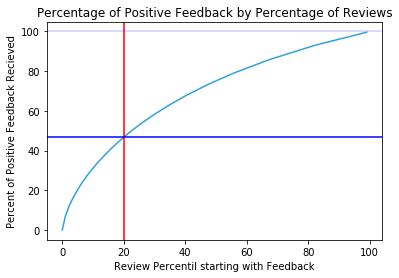

In [12]:
# From top 20 customers, Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
top_20= df['Positive Feedback Count'].sort_values(ascending=False)[:round(df.shape[0]*(20/100))]

inequatity=[]
for x in list(range(100)):
    inequatity.append(percentage_accumulation(top_20,x))
    
plt.plot(inequatity)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentil starting with Feedback")
plt.ylabel("Percent of Positive Feedback Recieved")
plt.axvline(x=20, c='r')
plt.axhline(y=47, c='b')
plt.axhline(y=100, c='b', alpha=.2)
plt.show()





In [13]:
#80-20 rule confirmation
print('{}% of positive feedback belongs to top 20% of customers'.format(round(percentage_accumulation(top_20,20))))

#Gini coefficient
print('\nGini coefficient: {}'.format(round(gini(top_20),2)))

##info: the 80-20 rule did not hold when we look on top 20 customers.

47.0% of positive feedback belongs to top 20% of customers

Gini coefficient: 0.38


## Division Name and Department Name Distribution:

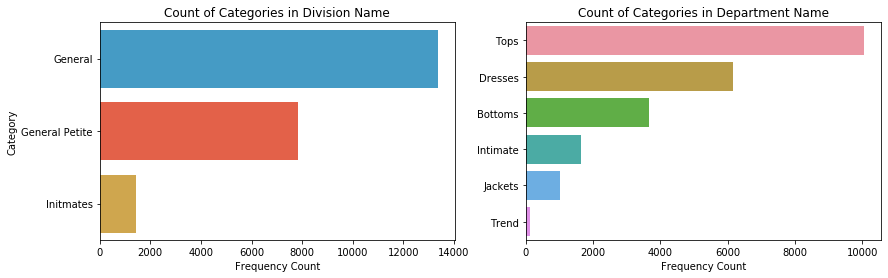

In [14]:
row_plots= ['Division Name', 'Department Name']
f, axes= plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df, order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title('Count of Categories in {}'.format(x))
    axes[i].set_xlabel('Frequency Count')
axes[0].set_ylabel('Category')
axes[1].set_ylabel('')
plt.show()
    
####value_counts()= table() in R, 若不加()則沒有作用
####order 表示factor的排序方式

####    info:
        the division name reveal the clothing size of customers leaving reviews. 
        We can compare this distribution with the whole customers population 
        to check whether a specific size customers tend more to leave review.
        
        the department name reveal that customers buying tops and dresses tend more to leave reviews, 
        a good direction to investigate!

## Distribution of Clothing ID to Understand Product Popularity

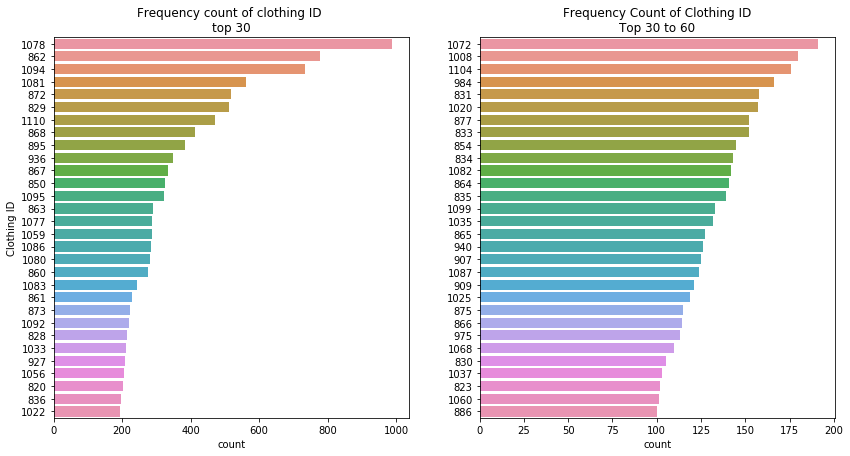

Dataframe dimension: 22628 Rows


mean         std   min    25%    50%    75%  \
Age                       42.7248   12.150429  18.0   34.0   41.0   51.0   
Rating                     4.1892    1.104306   1.0    4.0    5.0    5.0   
Recommended IND            0.8184    0.385592   0.0    1.0    1.0    1.0   
Positive Feedback Count    2.8624    6.773021   0.0    0.0    1.0    3.0   
Word Count                60.5912   28.731486   2.0   36.0   60.0   89.0   
Character Count          310.8604  144.836158  16.0  189.0  305.0  469.0   
Label                      0.9024    0.296832   0.0    1.0    1.0    1.0   

                           max  
Age                       99.0  
Rating                     5.0  
Recommended IND            1.0  
Positive Feedback Count   98.0  
Word Count               115.0  
Character Count          504.0  
Label                      1.0

In [15]:
# Clothing ID Category
f, axes = plt.subplots(1,2,figsize=[14,7])
num=30
sns.countplot(y='Clothing ID', data= df[df['Clothing ID'].isin(df['Clothing ID'].value_counts()[:num].index)],
             order=df['Clothing ID'].value_counts()[:num].index, ax=axes[0])
axes[0].set_title('Frequency count of clothing ID \ntop 30')
axes[0].set_xlabel('count')

sns.countplot(y='Clothing ID', data= df[df['Clothing ID'].isin(df['Clothing ID'].value_counts()[num:60].index)],
             order=df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel('')
axes[1].set_xlabel('count')

plt.show()

#### isin(values) method to Check whether `values` are contained in Series. 會返回一個bool list
#### .index 會給“在slice之前的data idx”

print('Dataframe dimension: {} Rows'.format(df.shape[0]))
df[df['Clothing ID'].isin([1078,862,1094])].describe().T.drop(['count'],axis=1).drop(['Clothing ID'],axis=0)

In [16]:
categorical=["Title", "Division Name","Department Name","Class Name"]

df.loc[df['Clothing ID'].isin([1078,862,1094]),categorical].describe(include=['O']).T.drop(['count'], axis=1)



unique              top  freq
Title             1815  Beautiful dress    21
Division Name        2          General  1524
Department Name      2          Dresses  1722
Class Name           2          Dresses  1722

In [17]:
for i in categorical[1:]:
    print(df.loc[df['Clothing ID'].isin([1078,862,1094]),i].value_counts(),'\n')

General           1524
General Petite     976
Name: Division Name, dtype: int64 

Dresses    1722
Tops        778
Name: Department Name, dtype: int64 

Dresses    1722
Knits       778
Name: Class Name, dtype: int64 



####    info:
    Top 3 ID are 1078, 862, 1094 and most of them are general size and dresses.
    The average recommended score is 81.8% and average rating is 4.2
    
    This is another good direction to find out the motivation
    

## Distribution of Class Name

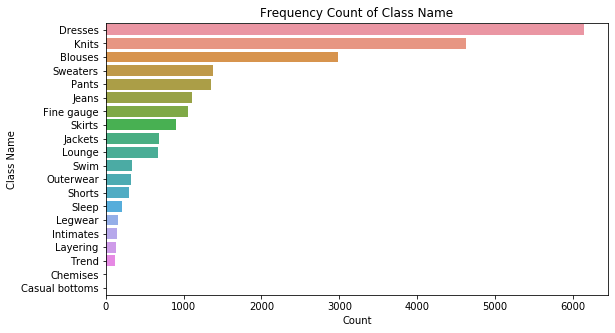

In [18]:
plt.subplots(figsize=(9,5))
sns.countplot(y='Class Name', data= df, order=df['Class Name'].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel('Count')
plt.show()


In [19]:
df.loc[df['Class Name'].isin(['Dress','Knits','Blousers','Sweaters','Pants']),].describe().T

count        mean         std   min    25%    50%  \
Clothing ID              7356.0  911.505710   85.888644   2.0  863.0  872.0   
Age                      7356.0   44.077488   12.533495  18.0   35.0   42.0   
Rating                   7356.0    4.171289    1.115503   1.0    4.0    5.0   
Recommended IND          7356.0    0.813214    0.389766   0.0    1.0    1.0   
Positive Feedback Count  7356.0    2.457722    5.392165   0.0    0.0    1.0   
Word Count               7356.0   57.005438   28.318188   2.0   33.0   54.0   
Character Count          7356.0  292.594889  143.391738  11.0  172.0  274.0   
Label                    7356.0    0.895188    0.306332   0.0    1.0    1.0   

                           75%     max  
Clothing ID              939.0  1205.0  
Age                       53.0    99.0  
Rating                     5.0     5.0  
Recommended IND            1.0     1.0  
Positive Feedback Count    2.0    95.0  
Word Count                83.0   114.0  
Character Count          428.0   504.0  
Label                      1.0     1.0

In [20]:
df.loc[df['Class Name'].isin(['Chemises','Casual bottoms']),].describe().T

count   mean        std    min     25%    50%  \
Clothing ID                2.0   27.5  24.748737   10.0   18.75   27.5   
Age                        2.0   32.0   8.485281   26.0   29.00   32.0   
Rating                     2.0    4.0   0.000000    4.0    4.00    4.0   
Recommended IND            2.0    1.0   0.000000    1.0    1.00    1.0   
Positive Feedback Count    2.0    0.0   0.000000    0.0    0.00    0.0   
Word Count                 2.0   29.5  14.849242   19.0   24.25   29.5   
Character Count            2.0  160.0  73.539105  108.0  134.00  160.0   
Label                      2.0    1.0   0.000000    1.0    1.00    1.0   

                            75%    max  
Clothing ID               36.25   45.0  
Age                       35.00   38.0  
Rating                     4.00    4.0  
Recommended IND            1.00    1.0  
Positive Feedback Count    0.00    0.0  
Word Count                34.75   40.0  
Character Count          186.00  212.0  
Label                      1.00    1.0

#### info:
    The top 6 class are 'Dress','Knits','Blousers','Sweaters','Pants'
    The average recommended ind is 81.3% and average rating is 4.17
    

## Distribution of Rating, Recommended IND, and Label:

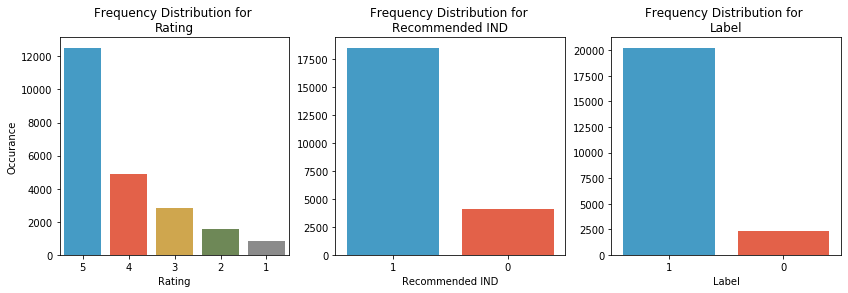

In [21]:
cat_types= [x for x,y,z in unique_count if y<10 and x not in ['Division Name',"Department Name"]]



f, axes= plt.subplots(1,len(cat_types),figsize=(14,4), sharex=False)

for i,j in enumerate(cat_types):
    sns.countplot(x=j, data=df, order=df[j].value_counts().index, ax=axes[i])
    axes[i].set_title('Frequency Distribution for \n{}'.format(j))
    axes[i].set_ylabel('Occurance')
    axes[i].set_xlabel('{}'.format(j))

for i in [1,2]:axes[i].set_ylabel('')   

plt.show()

#### info
Rating: the distribution is very right skewed, meaning that this store work well and customers are satisfied (at least for the most active customers)

Recommended IND, Label:  Label=1 is more than Recommended=1, a very interesting fact, meaning that products rated higher than 3 are not certainly recommeded.
We need to investigate the multivarite relation between rating and label, and dig out how customers express dislike.

## Word and Length:

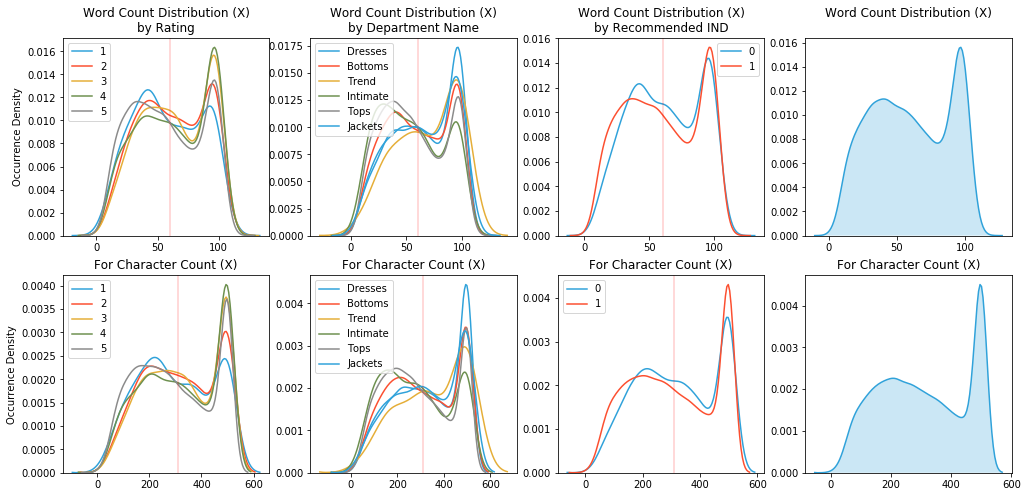

In [22]:
f, axes = plt.subplots(2,4, figsize=(17,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    ####決定 row 的 var
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        ####決定 col 的 var
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
            
            ####set 會提出每個“factor", eg. set(df['Rating'])只會剩下(1,2,3,4,5)
            ####這邊的每個迭代拆開，就是：sns.kdeplot(df['Word Count'][df['Rating']==1])，就是針對不同"Rating" 做filter
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
            axes[ii,i].axvline(x=60.22, c='r', alpha=0.2)
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
            axes[ii,i].axvline(x=308.76, c='r', alpha=0.2)
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()

plt.show()
    

In [23]:
print('Correlation Coefficient of Word Count and Character Count:{}'.format(
    round(df['Word Count'].corr(df['Character Count']),2)))
print('\nTotal Word Count is: {}'.format(df['Word Count'].sum()))
print('Total Character Count is: {}'.format(sum(df['Character Count'])))
df[['Word Count','Character Count']].describe().T

Correlation Coefficient of Word Count and Character Count:0.99

Total Word Count is: 1362476
Total Character Count is: 6986656


count        mean         std  min    25%    50%    75%  \
Word Count       22628.0   60.211950   28.533053  2.0   36.0   59.0   88.0   
Character Count  22628.0  308.761534  143.934126  9.0  186.0  302.0  459.0   

                   max  
Word Count       115.0  
Character Count  508.0

#### info: 
    almost perfect correlated between word count and character count. 

# Multivariate Distribution

## Categorical Variable by Categorical Variable
In this section, I utilize heatmaps to visualize the percentage occurrence pivot table. Note that I heavily utilized the technique of normalizing the proportion between variables classes by converting frequency into percentages. This technique is very fruitful because the relation upon which the percentage can be explored by aggregate, by index, and by column, each of which providing its own unique insight.

### Division Name by Department Name:

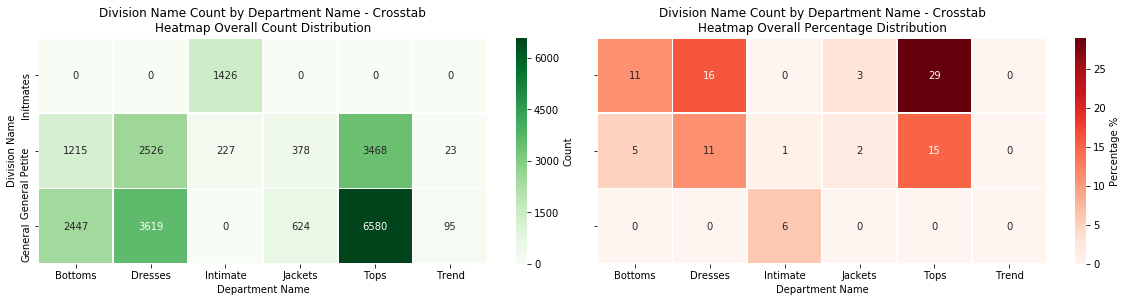

In [24]:
f, ax= plt.subplots(1,2,figsize=(16,4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name']),
            annot=True, linewidth=.5, ax=ax[0], fmt='g', cmap='Greens',
            cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')
####pd.crosstab = table(var1,var2) in R
####fmt='g' 表示用comma計數
####cmap='Greens'表示用Green色系
####cbar_kws={'label':'Count'}表示color bar的legend
####linewidth=.5 表示格子間的格線

sns.heatmap(pd.crosstab(df['Division Name'],df['Department Name'], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1], fmt='g', cmap='Reds', cbar_kws={'label':'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
#### normalize=True 表示換成各佔比，而非frequency
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
####tight_layout表示對圖像的壓縮
plt.show()


#### info: 
    we can see the most common reviewed product is normal size tops, and intimate does not have normal size.

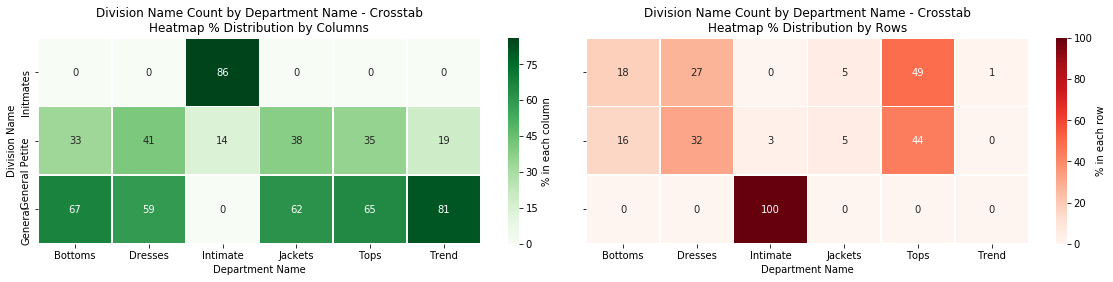

In [25]:
f, ax= plt.subplots(1,2, figsize=(16,4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize='columns').mul(100).round(0),
           annot=True, linewidth=.5, fmt='g', ax=ax[0], cmap='Greens', cbar_kws={'label':'% in each column'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')
####normalize='columns' 表示以“各col”內的百分比計算

sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize='index').mul(100).round(0),
           annot=True, linewidth=.5, fmt='g', ax=ax[1], cmap='Reds', cbar_kws={'label':'% in each row'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Rows')
####normalize='index' 表示以“各row”內的百分比計算
ax[1].set_ylabel('')
plt.tight_layout(pad=1)

plt.show()

#### info:
    General size is common in every product category, 
    the distribution by row( the second heatmap) is probably the distribution of sales?

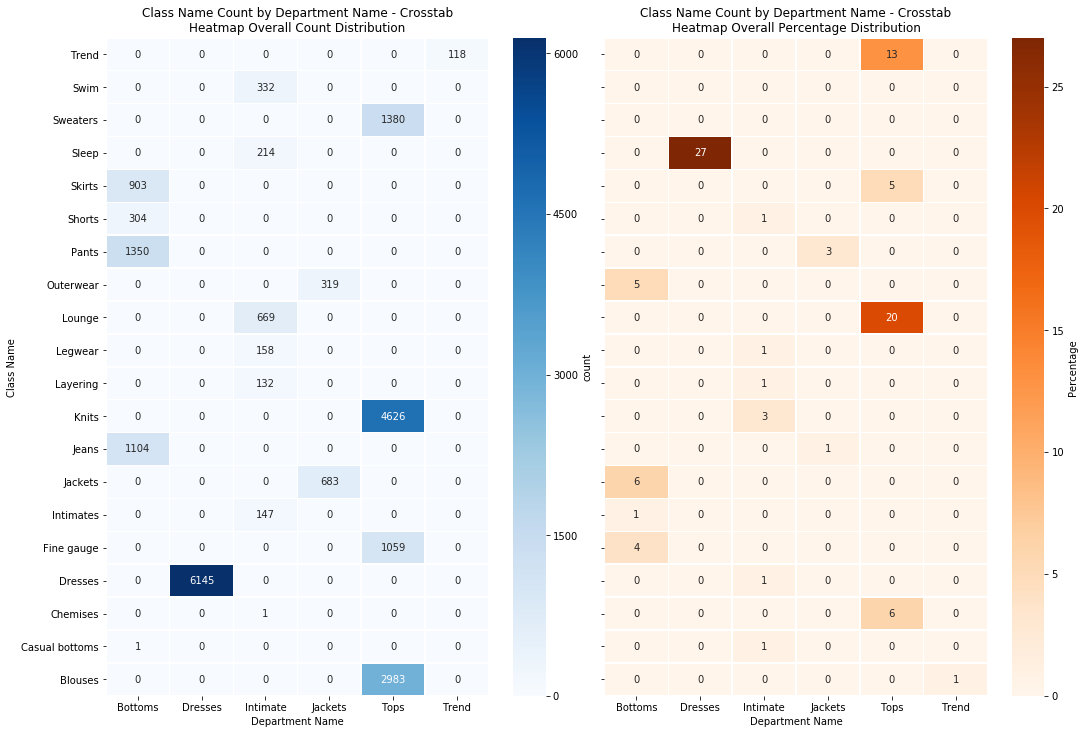

In [26]:
f,ax=plt.subplots(1,2,figsize=(15,10), sharey=True)


sns.heatmap(pd.crosstab(df['Class Name'],df["Department Name"]),
           annot=True, linewidth=0.5, ax=ax[0], fmt='g', cmap='Blues', cbar_kws={'label':'count'})
ax[0].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'],df['Department Name'], normalize=True).mul(100).round(0),
           annot=True, linewidth=0.5, ax=ax[1], fmt='g', cmap='Oranges', cbar_kws={'label':'Percentage'})
ax[1].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)

plt.show()

In [27]:
####試看看能不能寫成loop!

def draw_multiple_heatmap(df,x,y,size):
    f,ax = plt.subplots(2,2, figsize=size)
    normalize=(False, True, 'columns', 'index')
    col=['Greens','Reds','Blues','Oranges']
    by=['Overall','by Columns','by Rows']
    for n,k in enumerate(normalize):
        if n is 0:
            sns.heatmap(pd.crosstab(df[x],df[y]),
                        ax=ax[0,0], cmap= col[n], annot=True, linewidth=.5, fmt='g', cbar_kws={'label':'Count'})
            ax[0,0].set_title('{} Count by {} - Crosstab\nHeatmap Overall Count Distribution'.format(x,y))

        else:
            sns.heatmap(pd.crosstab(df[x],df[y],normalize=normalize[n]).mul(100).round(0),
                       ax=ax[n//2,n%2], cmap=col[n], annot=True, linewidth=.5, fmt='g', cbar_kws={'label':'%'})
            ax[n//2,n%2].set_title('{} Count by {} - Crosstab\nHeatmap {} Percentage Distribution'.format(x,y,by[n-1]))
    ax[0,1].set_ylabel('')
    ax[1,1].set_ylabel('')
    plt.tight_layout(pad=1.5)
    plt.show()    
    

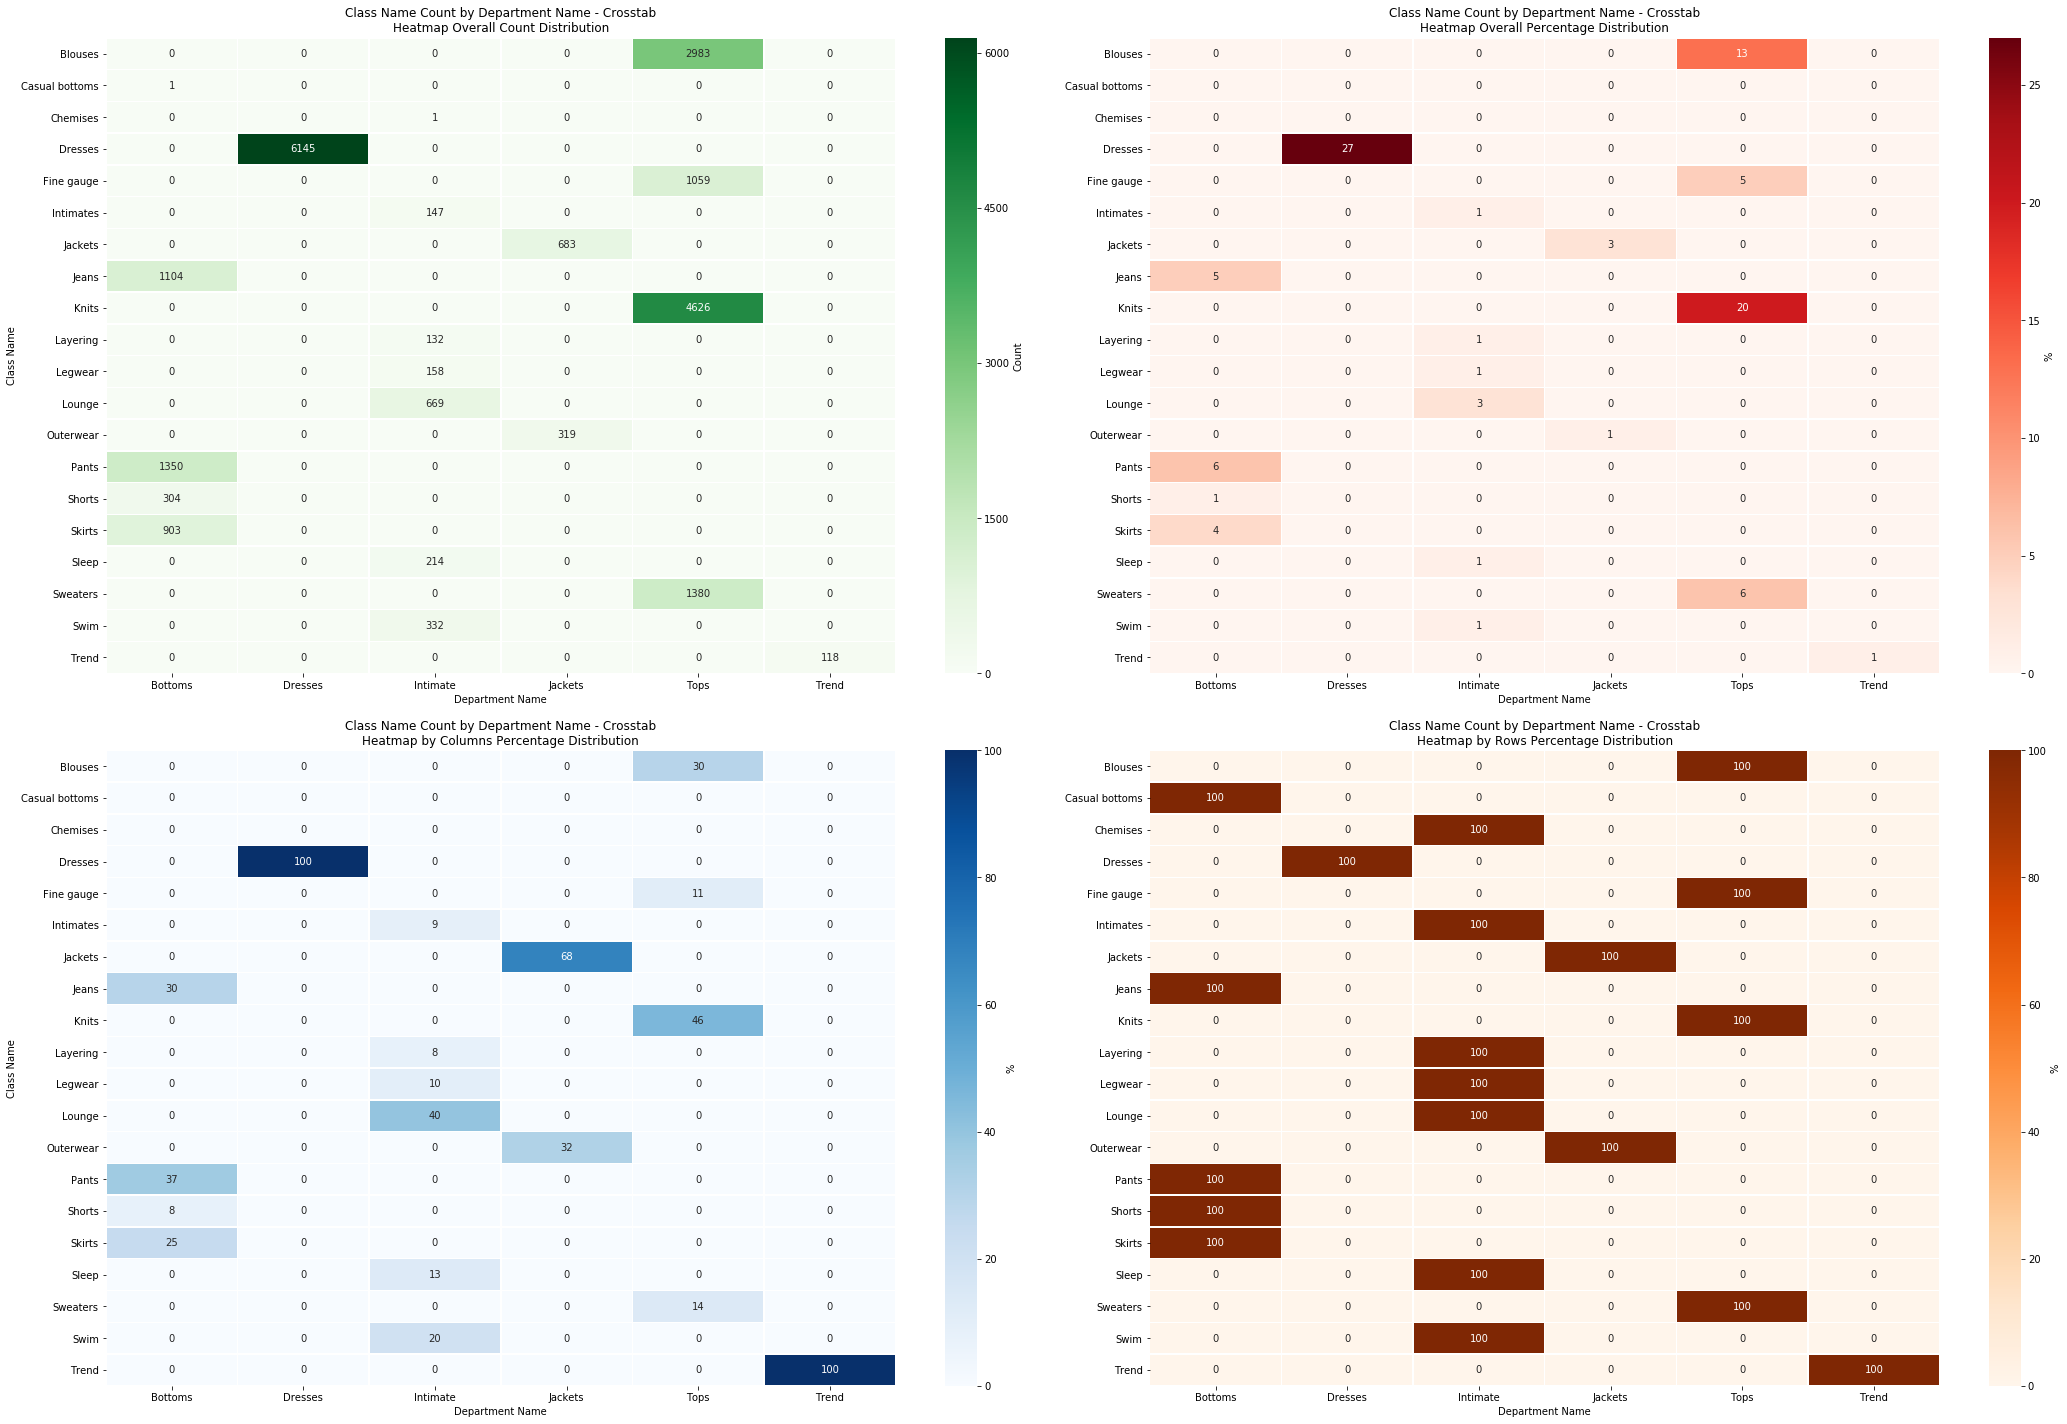

In [28]:
draw_multiple_heatmap(df,'Class Name','Department Name',(30,20))

## Continuous Variable by Categorical Variable

### Positive Feedback Count Distribution by Rating, Department Name, Recommended IND, and Class Name

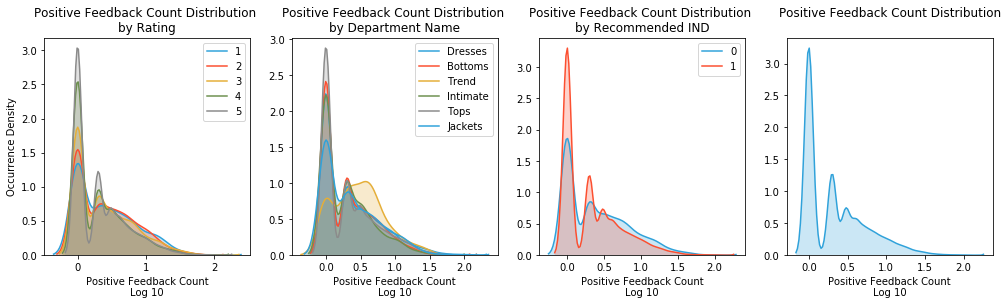

In [29]:
f, axes=plt.subplots(1,4,figsize=(17,4), sharex=False)

xvar='Positive Feedback Count'
plotdf=np.log10(df[xvar]+1)


for i,x in enumerate(["Rating","Department Name","Recommended IND"]):
    for v in set(df[x][df[x].notnull()]):
        sns.kdeplot(plotdf[df[x]==v], label=v, shade=True, ax=axes[i])
    axes[i].set_xlabel('{}\nLog 10'.format(xvar))
    axes[i].set_title('{} Distribution \nby {}'.format(xvar, x))
axes[0].set_ylabel('Occurrence Density')

#plot 4
sns.kdeplot(plotdf, shade=True, ax=axes[3])
axes[3].set_xlabel('{}\nLog 10'.format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
axes[3].legend_.remove()
plt.show()

#### 看不懂再想想：Since Positive Feedback Count is in log form, the higher frequency of non-recommended [0] has a bigger effect than visually suggested. The more popular reviews are not recommended, which suggest that the content is in the form of constructive criticism.

In [30]:
#checking inequality difference:
for rec in [0,1]:
    temp= df['Positive Feedback Count'][df['Recommended IND']==rec]
    print('Recommended is {}'.format(rec))
    #80-20 rule
    print('{}% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = {}'.format(
        round(percentage_accumulation(temp, 20)),rec))
    #GINI
    print('Gini Coefficient: {}\n'.format(round(gini(temp),2)))

Recommended is 0
75.0% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 0
Gini Coefficient: 0.73

Recommended is 1
78.0% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 1
Gini Coefficient: 0.76



#### info: 看不懂 The difference is not huge, but nevertheless, a higher gini coefficient signigies higher inequality. This means that there is a bigger divergence between recommended reviews than there is between non-recommended reviews.

### Positive Feedback Count by Class Name: 

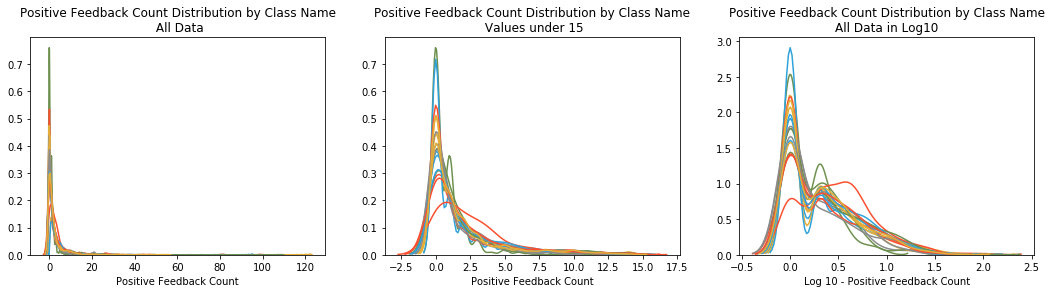

In [31]:
df = df[df['Class Name']!='Casual bottoms']
df = df[df['Class Name']!='Chemises']

f, axes = plt.subplots(1,3, figsize=(18,4), sharex=False)
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[0])
    
axes[0].legend_.remove()
axes[0].set_xlabel('{}'.format(xvar))
axes[0].set_title('{} Distribution by {}\n All Data'.format(xvar, "Class Name"))

min_value = 15
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][(df["Class Name"]==x) &
                                              (df["Positive Feedback Count"] < min_value)]
                ,label=x, shade=False, ax=axes[1])
    
axes[1].legend_.remove()
axes[1].set_xlabel('{}'.format(xvar))
axes[1].set_title('{} Distribution by {}\n Values under {}'.format(xvar, "Class Name", min_value))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(np.log10(df['Positive Feedback Count']+1)[df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[2])
    
axes[2].legend_.remove()
axes[2].set_xlabel('Log 10 - {}'.format(xvar))
axes[2].set_title('{} Distribution by {}\nAll Data in Log10'.format(xvar, "Class Name"))

plt.show()

In [32]:
#for x in set(df["Class Name"][df["Class Name"].notnull()]):
    #print(len(df['Positive Feedback Count'][df["Class Name"]==x]),x)

### Age Distribution by the Usual Suspects.. round them up

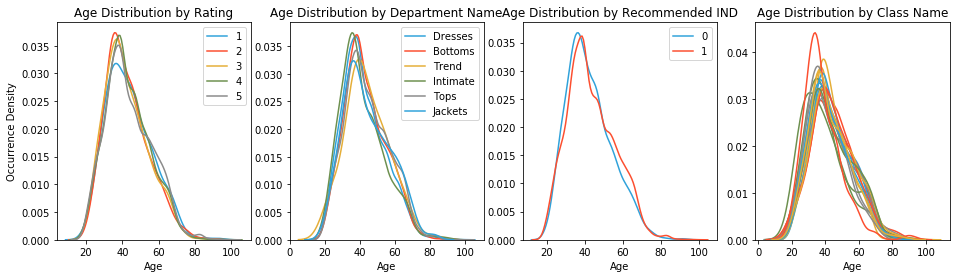

In [33]:
f, axes = plt.subplots(1,4, figsize=(16,4), sharex=False)
xvar='Age'
plotdf=df['Age']
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel('{}'.format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

for x in set(df['Class Name'][df['Class Name'].notnull()]):
    sns.kdeplot(plotdf[df['Class Name']==x], label=x, shade=False, ax=axes[3])

axes[3].legend_.remove()
axes[3].set_xlabel('{}'.format(xvar))
axes[0].set_ylabel('Occurrence Density')
axes[3].set_title('{} Distribution by {}'.format(xvar, "Class Name"))

plt.show()

#### info: age distribution is more normally distributed compared with positive feedback

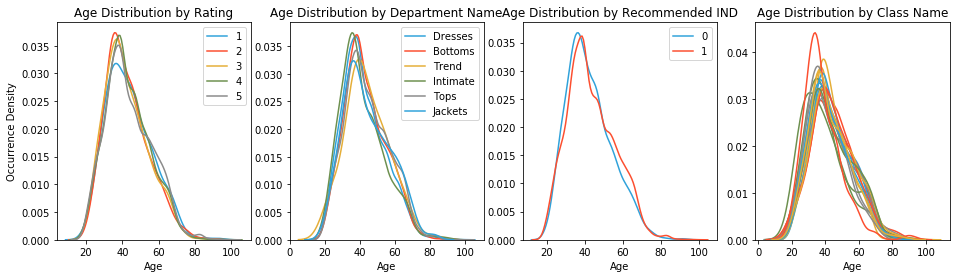

In [34]:
f, axes = plt.subplots(1,4, figsize=(16,4), sharex=False)
xvar = "Age"
plotdf = df["Age"]
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(plotdf[df["Class Name"]==x], label=x, shade=False, ax=axes[3])

axes[3].legend_.remove()
axes[3].set_xlabel('{}'.format(xvar))
axes[0].set_ylabel('Occurrence Density')
axes[3].set_title('{} Distribution by {}'.format(xvar, "Class Name"))
plt.show()

## Continuous Variables on Continuous Variables

### define function

In [35]:
def minmaxscaler(df):
    return (df-df.min())/(df.max()-df.min())
def zscorenormalize(df):
    return df-df.mean()/df.std()





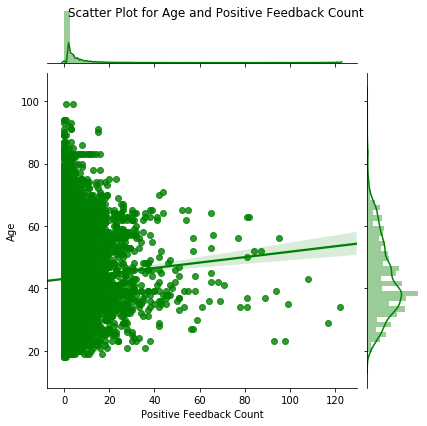

the corelation coefficient between age and positive feed back count is 0.041


In [36]:

g= sns.jointplot(x=df['Positive Feedback Count'], y=df['Age'], kind='reg', color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.show()

print("the corelation coefficient between age and positive feed back count is {}".format(
    round(df.Age.corr(df['Positive Feedback Count']),3)))


#### info:
the correlation coefficient is very small, while through the plot, we can see some relation between age and positive feed back count.

### Define Function: Percentage Standardize Distribution Plots

In [37]:
def percentstandardize_barplot(x,hue,data,ax=None, order=None):
    '''
    standardize by percentage the data using pandas functions, then plot using Seaborn.
    function arguments are extention of seaborns
    '''
    sns.barplot(x=x, y='Percentage', hue=hue, ax=ax, order=order,
                ####hue是計算y軸占比的值
               data= (data[[x,hue]]
                     .reset_index(drop=True)
                      ####把原本的index拿掉，不然後面無法reset
                     .groupby([x])[hue]
                      ####group by 會把 df 轉成series, 才能value_counts
                     .value_counts(normalize=True)
                      ####變成一個pivot table, index是x+hue
                     .rename('Percentage').mul(100)
                      ####先rename該組值，把pivot table 內的value＊100，注意：pivot table裡面其實只有一組value，其他的都是idx!
                     .reset_index()
                      ####把pivot table 的idx變成col, 此時data type 又變回“df”
                     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel('Percentage %')

####df[['Department Name', 'Recommended IND']].reset_index(drop=True).groupby(['Department Name'])['Recommended IND'].value_counts(normalize=True).mul(100).rename('Percantage').reset_index().sort_values('Recommended IND')
####reset_index會把本來的index 變成一個新的column

### Recommended IND by Department and Division

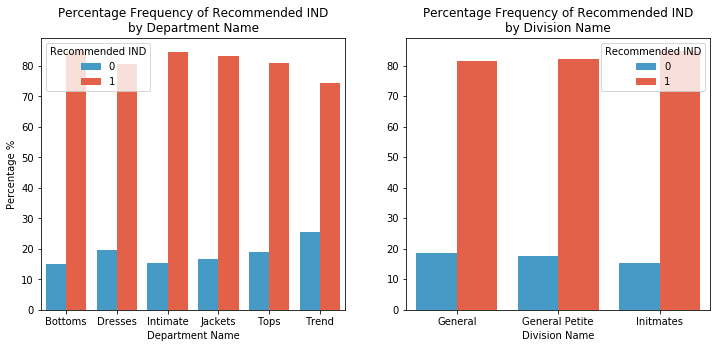

In [38]:


huevar='Recommended IND'
f, axes = plt.subplots(1,2, figsize=(12,5))
percentstandardize_barplot(x='Department Name', hue= huevar, data= df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby Department Name".format(huevar))
axes[0].set_ylabel('Percentage %')

percentstandardize_barplot(x='Division Name', hue= huevar, data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby Division Name".format(huevar))
axes[1].set_ylabel("")
plt.show()

### Rating by Department and Divison Name

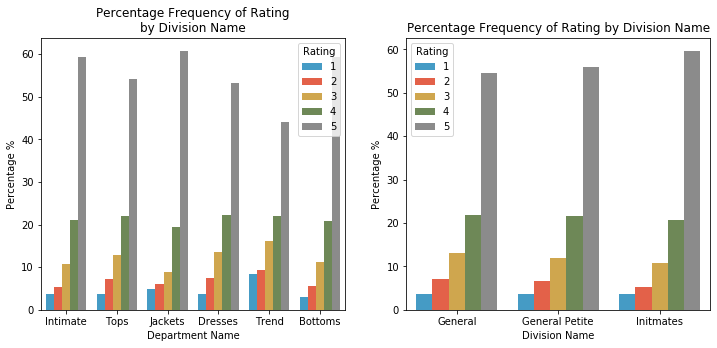

In [39]:
xvar= ["Department Name","Division Name"]
huevar= 'Rating'

f, axes = plt. subplots(1,2,figsize=(12,5))
for i in range(2):
    percentstandardize_barplot(x=xvar[i], hue=huevar, data=df, ax=axes[i])
    axes[0].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[i]))
axes[0].set_ylabel('Percentage %')
plt.show()

### Positive Feedback Count over 40 by Recomended IND and Rating

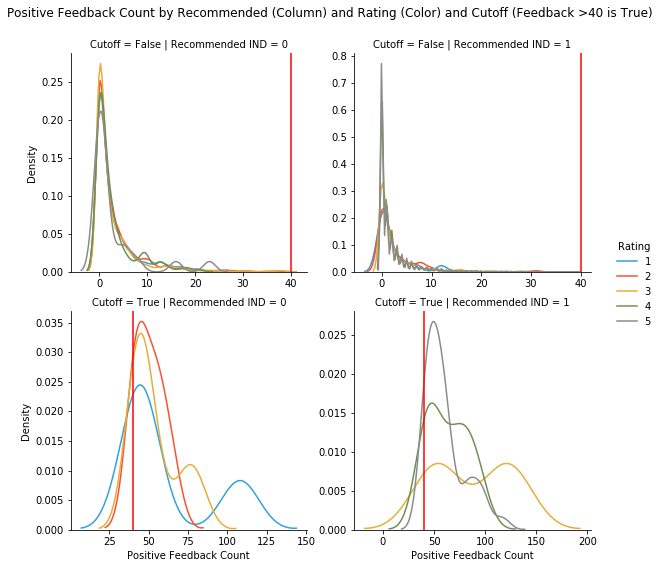

In [40]:
# Cuttoff Variable
df['Cutoff'] = df['Positive Feedback Count'] >= 40 ####temp variable for facetgrid
#facet grid plot
g= sns.FacetGrid(df, row='Cutoff', col='Recommended IND', hue= 'Rating', size=4, aspect=1, sharey=False, sharex=False)
####aspect 表示 一格x是幾格y
####hue表示用color作為第三個切分維度
####row 和 col都是一個切分維度，所以總共有四個facet
####row 的維度是 Positive feedback count 是否大於40
####col 是否為reccommended IND

g.map(sns.distplot, "Positive Feedback Count", hist=False)
####sns畫facet的邏輯是，先畫製一張facet畫布，給定切分標準(col)和切分值(row)
####map把給定的var畫製density plot
g.add_legend()
g.axes[0,0].set_ylabel('Density')
g.axes[1,0].set_ylabel('Density')
g.fig.suptitle('Positive Feedback Count by Recommended (Column) and Rating (Color) and Cutoff (Feedback >40 is True)')
plt.subplots_adjust(top=0.9)


# Give cutoff line to each plot.
for x in [0,1]:
    for y in [0,1]:
        g.axes[x,y].axvline(x=40, c='r')
        
plt.show()
del df['Cutoff']

#### info: 
    Some products are very unlikable, we can see this trend in the left bottom plot, 
    when feedback received > 100 positive feedback counts and rated 1 and did not recommend,
    meaning that this opinion was not subjective.
    
    Through the right bottom plot, we see the yellow line has two peak, meaning that some feedback with 3 rating 
    are thought very useful and customers have neutral opinions on these products while they still recommend the 
    products. We can find some constructive critism from these reviews.
    
    

##### Code Explanation: 
While I have mostly built my multi-plot visualization configuration from scratch, here is an facetplot example which is less complex, but nevertheless, requires careful planning of new variables/dimensions, such as my "Cutoff" variable.

The red vertical line corresponds to the cutoff rule. Note that KDE likes to smooth out its tails, even though the hard cutoff would contradict this. More realistic representation would appear with a barplot, but the clutter would be too in-intelligible.

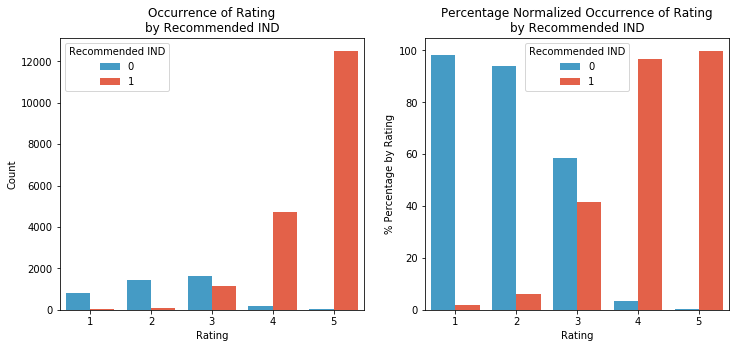

In [41]:
huevar= 'Rating'
f, axes = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x='Rating', hue='Recommended IND',data=df, ax=axes[0])
####記住，hue就是“用顏色加一個維度”！！！
axes[0].set_title('Occurrence of {}\nby {}'.format(huevar,'Recommended IND'))
axes[0].set_ylabel('Count')

percentstandardize_barplot(x='Rating', hue='Recommended IND',data= df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[1].set_ylabel("% Percentage by Rating")

plt.show()

#### info:
    From left plot, we see rating 3 is a watershed, customer rating > 3 recommended the products almost certainly. 
    Also, the store is doing very well.
    
    From right plot, we see customer rating 5 almost impossible not to recommend the product, and however they rated the product 1 score, they still probly recommend the product. 
    
    We can make a guess, these customers rating 1 recommended the product because the products did not fit their personal need,while overally, the product is still good.

## Multivariate Analysis and Descriptive Statistics
Now we look on some statistic

### Rating by Recommended IND

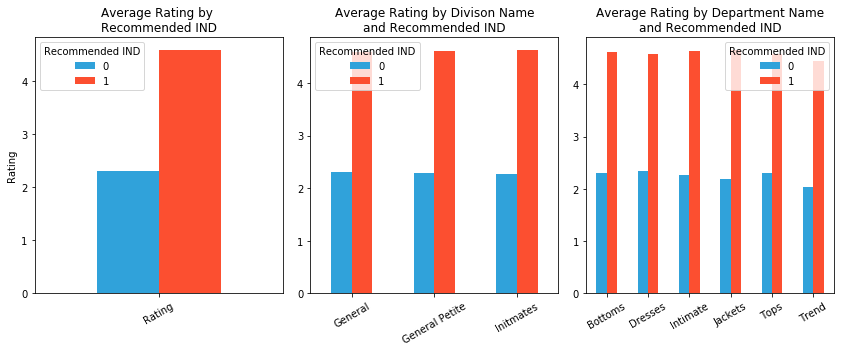

In [42]:
f, axes= plt.subplots(1,3,figsize=(12,5))
rot=30
df.pivot_table('Rating', columns=['Recommended IND']).plot.bar(ax=axes[0],rot=rot)
####邏輯： Pivot 會返回“average”, 然後再把這個frame拿去plot
####rot表示xlabel rotate 的度數！！！！
axes[0].set_title('Average Rating by \nRecommended IND')

df.pivot_table('Rating', index='Division Name', columns=['Recommended IND']).plot.bar(ax=axes[1], rot=rot)
###index 表示 row, col表示col, 由這四個維度去計算“avg Rating”
axes[1].set_title("Average Rating by Divison Name\nand Recommended IND")

df.pivot_table('Rating', index='Department Name', columns=['Recommended IND']).plot.bar(ax=axes[2],rot=rot)
####index(row) 會以“x軸”表示, column會以顏色表示
axes[0].set_ylabel("Rating")
axes[2].set_title("Average Rating by Department Name\nand Recommended IND")
for i in [1,2]:
    axes[i].set_xlabel('')
f.tight_layout()
plt.show()

#### info:
    customers recommending products gave almost full rating, however not recommending gave only half credit, this trend consists on all size and department.
    

### Correlating Average Rating and Recommended IND by Clothing ID

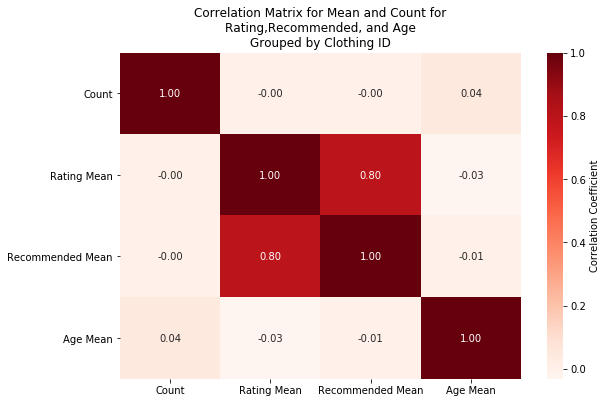

In [43]:
temp= (df.groupby('Clothing ID')[['Rating', 'Recommended IND','Age']].aggregate(['count','mean']))
#### groupby 的表達式：df.groupby('要group的col')['要計算的col'].aggregate('要計算的statistic')
temp.columns=["Count","Rating Mean","Recommended IND Count","Recommended Mean","Age Count","Age Mean"]
####原本的col index有 levels 和 labels 兩層，將其重新命名
temp.drop(["Recommended IND Count","Age Count"], axis=1, inplace=True)

#Plot Correlation Matrix
f,ax=plt.subplots(figsize=(9,6))
ax= sns.heatmap(temp.corr(), annot=True, fmt='.2f', cbar_kws={'label':'Correlation Coefficient'}, cmap='Reds')
####corr裡面沒給參數，表示df內部自己做cor, 和R裡面一樣
ax.set_title("Correlation Matrix for Mean and Count for\nRating,Recommended, and Age\nGrouped by Clothing ID")
plt.show()

#### info:
    The correlation between mean and count is zero, meaning that the populatity is nothing to do with average score.
    At the same time, recommended mean is highly correlated with rating mean, a really resonable fact.

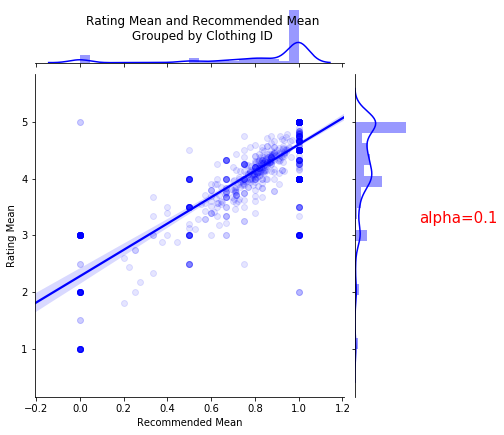

In [44]:
g=sns.jointplot(x='Recommended Mean', y='Rating Mean', data=temp, kind='reg', color='b',scatter_kws={'alpha':0.1})
####plt直接用alpha=float調整, sns用scatter_kws={'alpha':float}調整
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Rating Mean and Recommended Mean\nGrouped by Clothing ID")
g.fig.text(s='alpha=0.1',y=0.5,x=1,size=15, color='Red')

####有多個圖時用ax.set_title, 單一圖時用g.fig.suptitle
plt.show()

#### info: 
    we can focus on products on the left bottom side to improve customers experience.
    

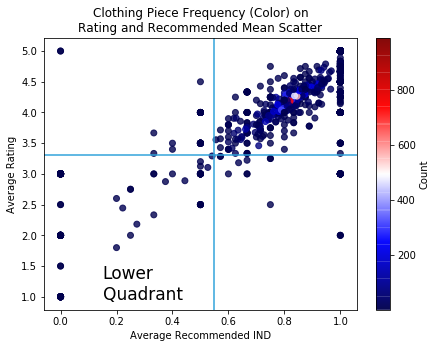

In [45]:
plt.subplots(figsize=(7,5))
plt.scatter(temp['Recommended Mean'],temp['Rating Mean'], alpha=0.8, c=temp['Count'], cmap='seismic')
####用plt畫point plot的畫法
cbar= plt.colorbar()
####加上colorbar()
cbar.set_label('Count', rotation=90)
####因為要調整colorbar，所以上面用變數命名的方式，不過即使只是命名變數，也會在plt物件上作出調整
plt.xlabel("Average Recommended IND")
plt.ylabel("Average Rating")
plt.title("Clothing Piece Frequency (Color) on\nRating and Recommended Mean Scatter")

#vertical and horizontal lines
l=plt.axhline(y=3.3)
l=plt.axvline(x=.55)
# Text
plt.text(.15,1,"Lower\nQuadrant", ha='left', wrap=True, fontsize=17)
plt.show()




In [46]:
# Descriptives for LOW QUADRANT
temp[(temp['Rating Mean']<3.3)|(temp['Recommended Mean']<=.55)].describe().T

count       mean        std   min        25%        50%  \
Count             204.0   2.308824   2.798261   1.0   1.000000   1.000000   
Rating Mean       204.0   2.763338   0.819220   1.0   2.136364   3.000000   
Recommended Mean  204.0   0.316315   0.351723   0.0   0.000000   0.250000   
Age Mean          204.0  41.883954  10.858979  20.0  34.687500  41.142857   

                   75%   max  
Count              2.0  24.0  
Rating Mean        3.0   5.0  
Recommended Mean   0.5   1.0  
Age Mean          47.0  74.0

In [47]:
#Descriptives for High QUADRANT
temp[(temp['Rating Mean']>=3.3)|(temp['Recommended Mean']>.55)].describe().T



count       mean        std   min        25%        50%  \
Count             1039.0  21.503369  71.379267   1.0   1.000000   2.000000   
Rating Mean       1039.0   4.405403   0.558729   2.0   4.000000   4.434783   
Recommended Mean  1039.0   0.909745   0.145134   0.0   0.833333   1.000000   
Age Mean          1039.0  41.938486   9.256593  19.0  36.000000  42.111111   

                   75%    max  
Count              8.0  987.0  
Rating Mean        5.0    5.0  
Recommended Mean   1.0    1.0  
Age Mean          46.5   80.0

#### info:
    the low quadrant only has an average count of 2.3, meaning that the ratings of this quadrant are highly affected by few customers, we could treat these customers as outliers but still need to investigate what is the effect they have made.

### Correlating Average Rating and Recommended IND by Class Name 

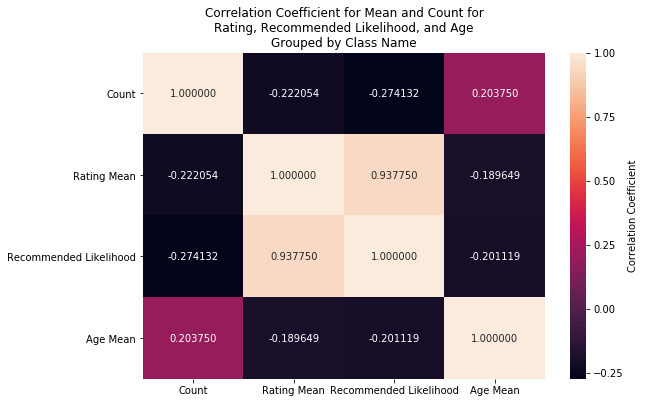

Class Categories:
 ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering']


In [48]:
key='Class Name'
temp=(df.groupby(key)[["Rating","Recommended IND", "Age"]].aggregate(['count','mean']))
temp.columns=["Count","Rating Mean","Recommended Likelihood Count",
                "Recommended Likelihood","Age Count","Age Mean"]
temp.drop(["Recommended Likelihood Count","Age Count"], axis=1, inplace=True)

#plot Correlation Matrix
f,ax=plt.subplots(figsize=[9,6])
ax=sns.heatmap(temp.corr()
              ,annot=True, fmt='f',cbar_kws={'label':'Correlation Coefficient'})
ax.set_title("Correlation Coefficient for Mean and Count for\nRating, Recommended Likelihood, and Age\nGrouped by {}".format(key))
plt.show()
print('Class Categories:\n',df['Class Name'].unique())

#### info:
    There is a very strong relation between avg age and recommended likelihood, we shall take a look.

Empty DataFrame
Columns: [Count, Rating Mean, Recommended Likelihood, Age Mean, resid]
Index: []

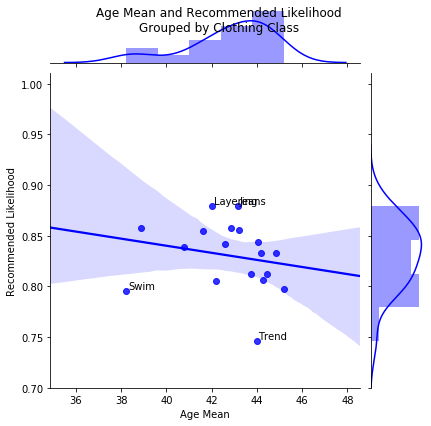

In [49]:
# Simple Linear Regression Model
model_fit=sm.OLS(temp['Recommended Likelihood'],sm.add_constant(temp['Age Mean'])).fit()
####OLS的格式為：sm.OLS(y= vector, x=array)
####拿age mean 作為independent，並在前面加上一個constant 1 array, 亦即“model中有intercept”, sm的預設是不會有intercept
####sm.add_constant(array)會在該array加上一個I vector
temp['resid']=model_fit.resid

#plot
g=sns.jointplot(y='Recommended Likelihood', x='Age Mean', data=temp, kind='reg', color='b')
g.fig.suptitle('Age Mean and Recommended Likelihood\nGrouped by Clothing Class')
plt.ylim(.7,1.01)
####plt 一樣可以用ylim調整 y軸顯示大小

# Annotate Outliers
head=temp.sort_values(by=['resid'],ascending=[False]).head(2)
tail=temp.sort_values(by=['resid'],ascending=[False]).tail(2)

def ann(row):
    ind=row[0]
    r=row[1]
    plt.gca().annotate(ind,xy=(r['Age Mean'], r['Recommended Likelihood']),xytext=(2,2), textcoords='offset points',)
####Annotate註釋 the point ``xy`` with text ``s``
####plt.GCF() or plt.GCA() = Get Current Figure 和 Get Current Axes
for row in head.iterrows():
####iterrows: Iterate over DataFrame rows as (index, Series) pairs.
    ann(row)
for row in tail.iterrows():
    ann(row)
    
del head, tail
temp[temp['Recommended Likelihood']>.95]

# Working with Text 

## Text Pre-Processing
code example: https://www.yiibai.com/pandas/python_pandas_options_and_customization.html

In [50]:
#?pd.set_option
#pd.reset_option('max_colwidth')
#print(pd.get_option('max_colwidth'))
#pd.set_option('max_colwidth',500)
#print(pd.get_option('max_colwidth'))

In [51]:
pd.set_option('max_colwidth',500)
####調整pd的顯示預設，eg. 此處調整col最寬可以到多寬
df[["Title","Review Text", "Rating"]].sample(7)

Title  \
11499  Great price (on sale) but sheds too much!   
1878                         Nice knit button up   
10502                            Too many pleats   
12491                                        NaN   
18635                                Swanky fun!   
793        If only it looked like the photo.....   
19385                              Very cute top   

                                                                                                                                                                                                                                                                                                                                                                                                                       Review Text  \
11499                                                                                                                                             Loved the sweater and the sale price was great, but i could not take the shedding! even after just trying it on the first time, my jeans and top had shedding all over them. this was 2 minutes, i could not imagine what i would look like if i wore it all day. had to return.   
1878                                                                                                                                                                                                                                                         I was pleasantly surprised when this arrived. it hangs in a flattering way and the red has a nice soft hue. i couldn't believe what a great deal i got while on sale.   
10502                                                                                                                                                                                                                                                                                               There were just too many pleats to this thing. it was not flattering. it looks fantastic on this model but not on me. oh well.   
12491                                                                                                                                                                                                                                                                                         Recommend this vest - nice design - fabric is thicker than expected - might suggest a size smaller - plenty of room in loose styling   
18635                                                                                                                                                    This elegant tank made me feel as if i had been transported to downton abbey. the velvet trim and the lovely embellishments of sparkle have an art deco delight. the swing of the fabric was playful and flattering. it's easy to dress up and dress down. fantastic top!   
793    This sweater was a big let down. i am 5'2" so i ordered it in a petite. it was so short that if i lifted my arms, you'd see my bra!! there is no way i could wear it without something under it- even with high waisted bottoms. and the bell sleeves look nothing like the pic. the entire sleeve is just wide, and it continues with little increase into the cuff. it is just short and boxy. it is going back for sure.   
19385                                                                                                                              I really liked the top once i saw it, but it needs to be worn with a cami underneath. the fabric is a little stiff. it runs true to size and it fits like a peplum top with extra space around the waist. the top is not really crocheted by hand it was done by machine, but it is a nice top.   

       Rating  
11499       2  
1878        5  
10502       2  
12491       3  
18635       5  
793         1  
19385       3

## Lowercase, stopwords, puntuation, tokenize, 

In [52]:
import nltk
nltk.download('stopwords')
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import  PorterStemmer

ps=LancasterStemmer()
ps=PorterStemmer()

tokenizer= RegexpTokenizer(r'\w+')
####設定一個切分器，這個切分器需要表明一個pattern, r表示regular, 後面使用regular expression來表示
####A ``RegexpTokenizer`` splits a string into substrings using a regular expression.
####'\w+' 表示任一字母或數字，無論重複幾次，表示一個“token”
#### see: https://www.nltk.org/_modules/nltk/tokenize/regexp.html
#### regular expression: https://ithelp.ithome.com.tw/articles/10197315
stop_words=set(stopwords.words('english'))

def preprocessing(data):
    txt=data.str.lower().str.cat(sep=' ')
    #### pd.series.str.lower(): Return a copy of the string converted to lowercase. 
    #### str.lower()後仍是series, 且一個obj是一個句子, 而非word
    #### pd.series.str.cat() :Concatenate strings in the Series/Index with given separator
    #### see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.cat.html
    #### 經過str.cat(sep='') 之後，將整個series collection 合併成單一str obj, 原先的每個子物件，會以sep=''指定的符號分隔
    words = tokenizer.tokenize(txt)
    ####tokenize 後，本來的str被切分成list collection, 一個obj是一個word
    #### 所以記住，tokenizer 只吃單一“str”
    words=[w for w in words if w not in stop_words]
    #words = [ps.stem(w) for w in words]
    return words


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>


# 上面記得整理邏輯！！！！！

##### proper noun:
stopwords: 
words such as the, a, an, as, to ... the words mean very few to the whole context.

tokenize:
Slice sentences into "words", eg: Slicing: I love you into "I", "love", "you"

In [53]:
#preprocessing(df['Review Text'])

## Sentiment Analysis
Checking how the text review relates to the rating, find out the positive and negative sentiment behaind the text.

In [54]:
# Pre-Processing 
##import nltk
nltk.download('vader_lexicon')
SIA = SentimentIntensityAnalyzer()
####Give a sentiment intensity score to sentences
df['Review Text'] = df['Review Text'].astype(str)
####Cast a pandas object to a specified dtype

# Applying Model, Variable Creation
df['Polarity Score']=df['Review Text'].apply(lambda x:SIA.polarity_scores(x)['compound'])
#### lambda arg1, arg2... : mapping you want to run; it will return the result automatically.
df['Neutral Score']= df['Review Text'].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df['Review Text'].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df['Review Text'].apply(lambda x:SIA.polarity_scores(x)['pos'])

#Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0, 'Sentiment']='Positive'
####df.loc[row, col]!!!
df.loc[df['Polarity Score']==0, 'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0, 'Sentiment']='Negative'


[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>


In [55]:
df['Sentiment'].value_counts()

Positive    21051
Negative     1435
Neutral       140
Name: Sentiment, dtype: int64

#### info:
    It seems that customers resoponsed really positively, as we see in the previous exploratory analysis

###### Explaination
    Neutral/Negative/Positive Score: 
    Indicates the potency of these classes between 0 and 1.

    Polarity Score: 
    Measures the difference between the Positive/Neutral/Negative values, 
    where a positive numbers closer to 1 indicates overwhelming positivity, 
    and a negative number closer to -1 indicates overwhelming negativity.

### Normalize Plots for Sentiment Distribution

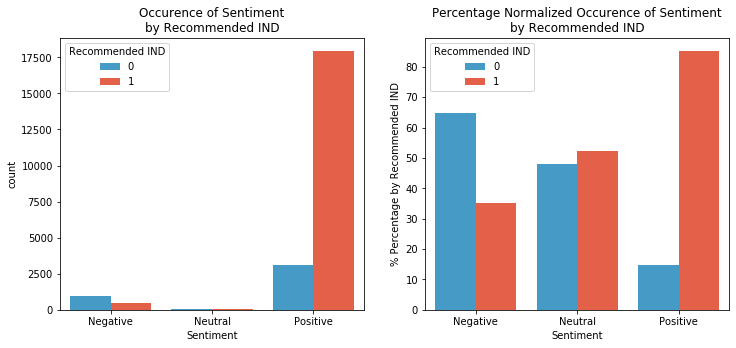

In [56]:
huevar='Recommended IND'
xvar='Sentiment'
f,axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar, data=df, ax=axes[0], order=['Negative', 'Neutral', 'Positive'])
axes[0].set_title('Occurence of {}\nby {}'.format(xvar,huevar))

percentstandardize_barplot(x=xvar, hue=huevar, data=df,ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))

plt.show()

#### info: 
    just as our expectation, the recommended IND is highly correlated with sentiment

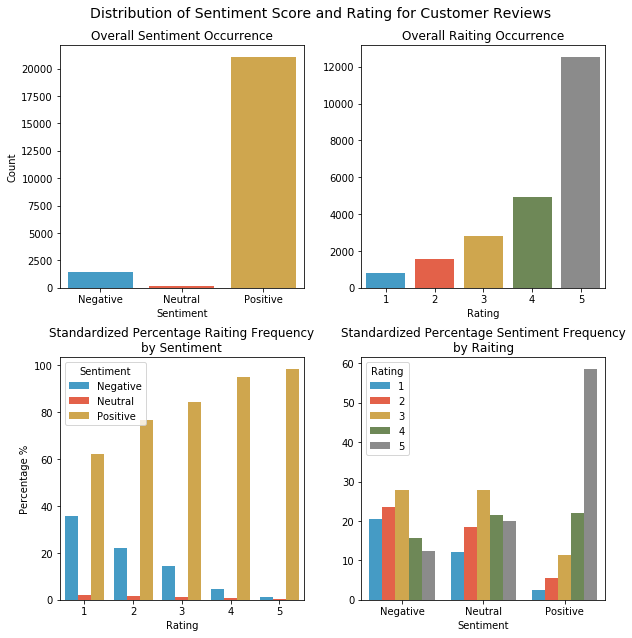

In [57]:
f, axes = plt. subplots(2,2,figsize=(9,9))
sns.countplot(x='Sentiment', data=df, ax=axes[0,0], order=["Negative","Neutral","Positive"])
####注意，order 可以直接用list給
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")
axes[0,0].set_title("Overall Sentiment Occurrence")

sns.countplot(x='Rating', data=df, ax=axes[0,1])
axes[0,1].set_xlabel("Rating")
axes[0,1].set_ylabel("")
axes[0,1].set_title("Overall Raiting Occurrence")

percentstandardize_barplot(x='Rating', hue='Sentiment', ax=axes[1,0], data=df)
axes[1,0].set_xlabel("Rating")
axes[1,0].set_ylabel("Percentage %")
axes[1,0].set_title("Standardized Percentage Raiting Frequency\nby Sentiment")

percentstandardize_barplot(x='Sentiment', hue='Rating', ax=axes[1,1], data=df)
axes[1,1].set_ylabel("Occurrence Frequency")
axes[1,1].set_title("Standardized Percentage Sentiment Frequency\nby Raiting")
axes[1,1].set_xlabel("Sentiment")
axes[1,1].set_ylabel("")

f.suptitle("Distribution of Sentiment Score and Rating for Customer Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
####把整個subplot移動，此處表示上界位於 .92處，為了不讓suptitle 和 subplot title 重疊！
plt.show()

#### info:
    1. customers tend not to give too "negative" feedback, we can see this trend from the left bottom plot, 
    showing that customers left rating 1 still use more "positive" words. 
    2. customers tend to rate products with a neutral score, we can see this trend from the right bottom plot, 
    showing that customers ususally left rating 3 eventhough they have negative emotion.

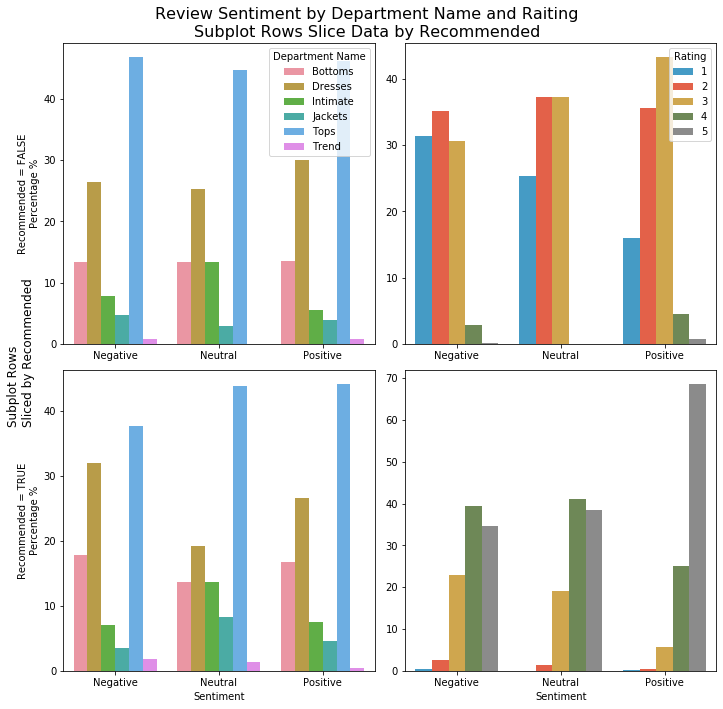

In [58]:
# Tweakable Variables (Note to Change Order Arguement if Xvar is changed)
xvar= 'Sentiment'
huevar = 'Department Name'
rowvar = 'Recommended IND'

# Plot
f, axes = plt. subplots(2,2, figsize= (10,10), sharex= False, sharey= False)

for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar, hue=huevar, data=df[df[rowvar]==x],
                              ax=axes[i,0], order=["Negative","Neutral","Positive"])
    percentstandardize_barplot(x=xvar, hue='Rating', data=df[df[rowvar]==x],
                               ax=axes[i,1], order=["Negative","Neutral","Positive"])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,0].set_ylabel("Recommended = FALSE\nPercentage %")
axes[1,0].set_ylabel("Recommended = TRUE\nPercentage %")
axes[1,1].set_title("")

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle("Review Sentiment by Department Name and Raiting\nSubplot Rows Slice Data by Recommended", fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.show()

#### info: 
    When customers recommend a item, they usually rate the item higher than 3 even though they have negative emotion.
    

### Correlation Matrix

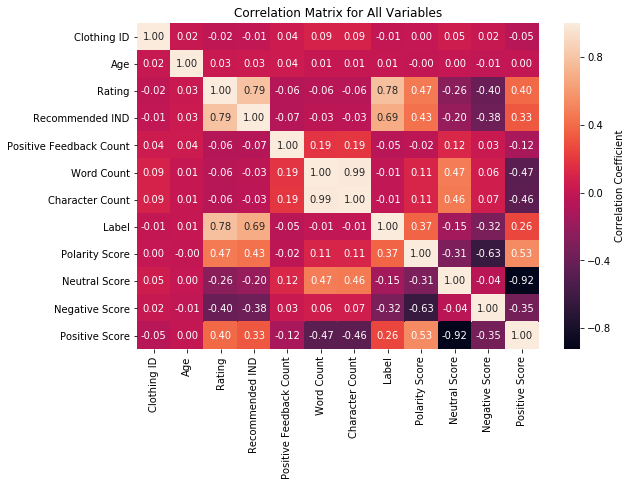

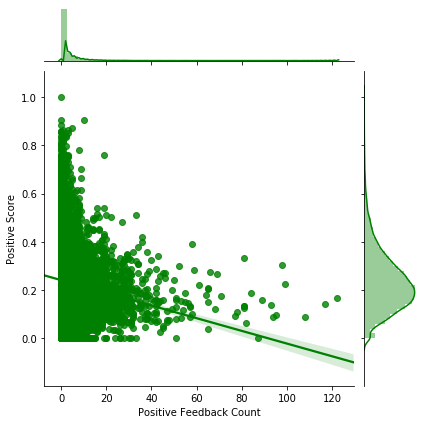

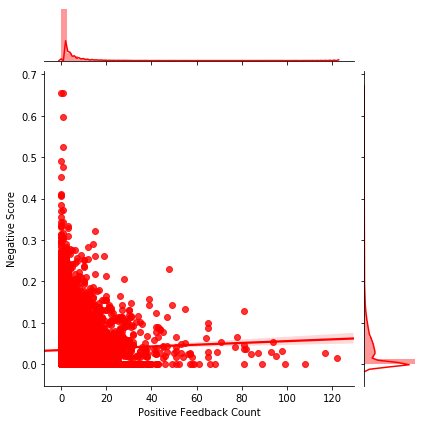

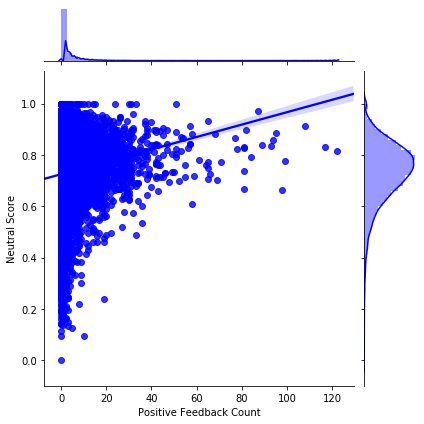

In [59]:
# All variables
f, ax = plt.subplots(figsize=(9,6))
ax= sns. heatmap(df.corr(), annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Matrix for All Variables")
plt.show()

# Sentiment Positivity Score by Positive Feedback Count
ax= sns.jointplot(x=df['Positive Feedback Count'], y=df['Positive Score'], kind='reg', color='g')
plt.show()

ax= sns.jointplot(x=df['Positive Feedback Count'], y=df['Negative Score'], kind='reg', color='r')
plt.show()

ax= sns.jointplot(x=df['Positive Feedback Count'], y=df['Neutral Score'], kind='reg', color='b')
plt.show()

#### info: 
    customers consider netral feedback more useful.
    However,  The correlation coefficient with positive feedback count of positive and negative score are reverse.
    Maybe customers don't like strong emotion feedback
    

# Word Distribution and Word Cloud

## define fuction

In [60]:
stopwords = set(STOPWORDS)
size= (10,7)

def cloud(text, title, stopwords=stopwords, size=size, fontsize=50):
    '''
    Function to plot WordCloud
    '''

    #Setting figure parameters
    mpl.rcParams['figure.figsize']=(10,10)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=300
    mpl.rcParams['figure.subplot.bottom']=.1
    ####rcParams 是設定mpl的像素相關值

    #Processing Text: skip here, because of it redudants when combined with the previously define Preprocessing function

    #create wordcloud object
    wordcloud=WordCloud(width=1600, height=800, background_color='black', stopwords=stopwords).generate(str(text))
    ####WordCloud.generate() 吃的是text (ie: np.array), 不能餵list
    ####The input "text" is expected to be a natural text. 
    ####If you pass a sorted list of words, words will appear in your output twice. To remove this duplication, set ``collocations=False``.

    #output visualization
    fig=plt.figure(figsize=size, dpi=100, facecolor='k', edgecolor= 'k' )
    ####create a new fig, just like plt.subplot
    plt.imshow(wordcloud, interpolation='bilinear')
    ####Display an image on the axes.
    plt.axis('off')
    plt.title(title, fontsize=fontsize, color='y')
    plt.tight_layout(pad=0)
    plt.show()


# Frequency Calculation [One-Gram]
def wordfreq(text, x):
    word_dist=nltk.FreqDist(text)
    ####nltk.FreqDist(str list) 會算每個字數出現的次數，回傳的obj是FreqDist物件，而非list
    top_n=x
    rslt = pd.DataFrame(word_dist.most_common(top_n), columns=['Word', 'Frequency']).set_index('Word')
    ####執行most_common mathod 後，回傳變成tuple list
    return rslt

##### code explaination:
    This code creates the word cloud visualization function. This function’s mathematical processes are hidden, since it does not explicitly state that it determines the frequency occurrence of each word in relation to the entire dictionary of words. Within the function, the Setting Function Parameter section creates the graphic structure using matplotlib. Then the text is formatted, and the word frequency is determined. Finally, the matplotlib structure is filled with words, where the larger the word size, the higher the word occurrence.

## Visualize Titles

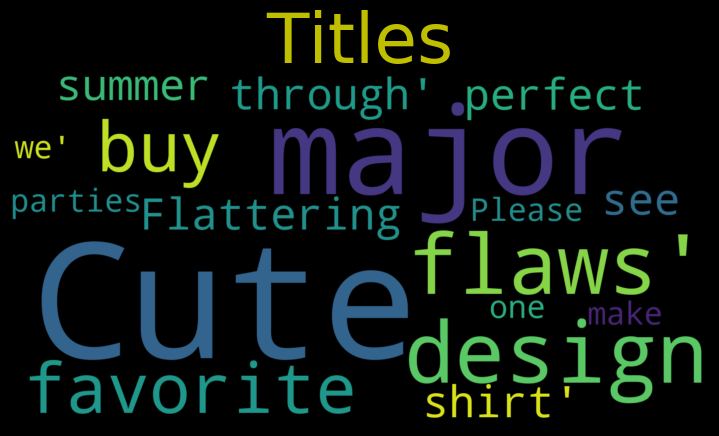

In [61]:
# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop=set(STOPWORDS)
####淺複製
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())] 
                + ['dress', 'petite'])
#Cloud

cloud(text= df.Title[df.Title.notnull()].astype(str).values,
####astype(str)後, 還是pd.series
####values後變成 np.array (去掉pd.series的idx) 
      title = 'Titles',
      stopwords=new_stop,
      size=(7,4))

## Visualize Review

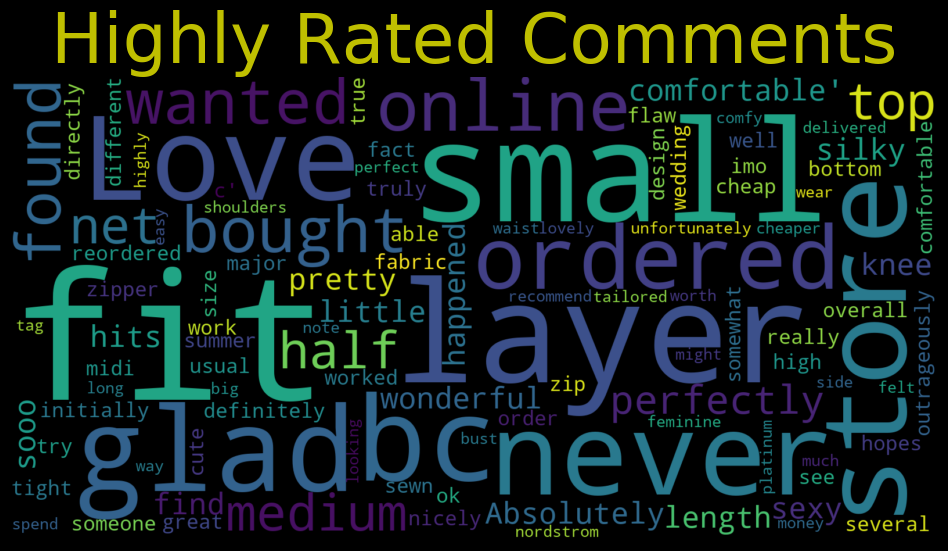

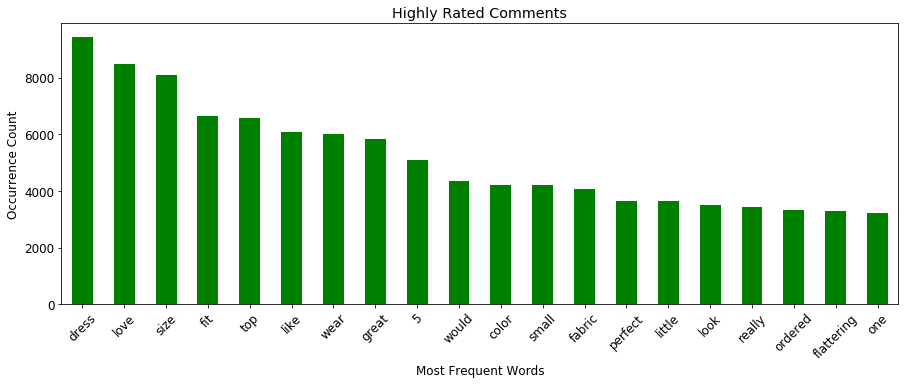

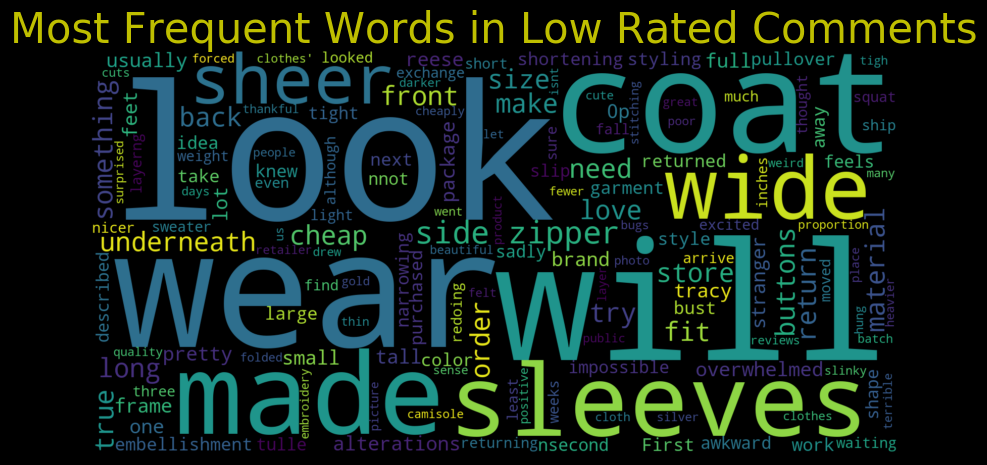

In [62]:
# Highly Rated 
title='Highly Rated Comments'
temp= df['Review Text'][df.Rating.astype(int) >=3]
#Modify Stopwords to Exclude Class type, such as 'dress'
new_stop=set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
               + ['dress', 'petite'])

#Cloud
cloud(text= temp.values, title=title, stopwords=new_stop)

#Bar chart
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False, figsize=(15,5), color='g', title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()

#Low Rated
title = "Most Frequent Words in Low Rated Comments"
temp = df['Review Text'][df.Rating.astype(int)<3]

#Modify Stopwords to Exclude Class types, such as 'dress'
new_stop=set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
               + ["dress", "petite", "skirt","shirt"])

#Cloud
cloud(temp.values, title= title, stopwords= new_stop, fontsize= 30)
####如果不調整fontsize的話，title的字體太大，會把底下的圖壓到非常小，因為低評分本身很少，所以每個字的count太少了

#### info: 
    we now know the most frequent words considering highly and low rated.
    However, we DO NOT KNOW the context, missing so much info.

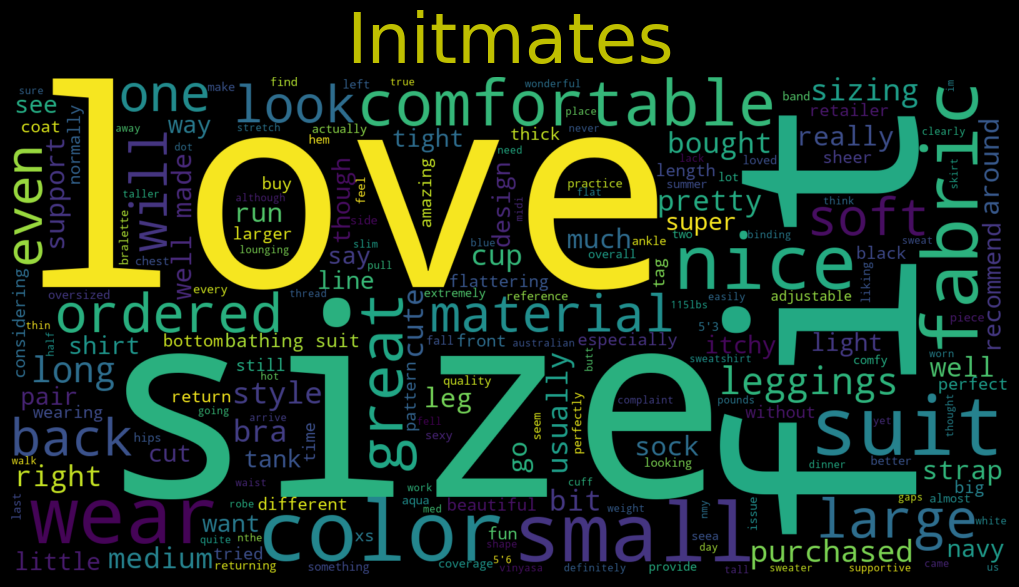

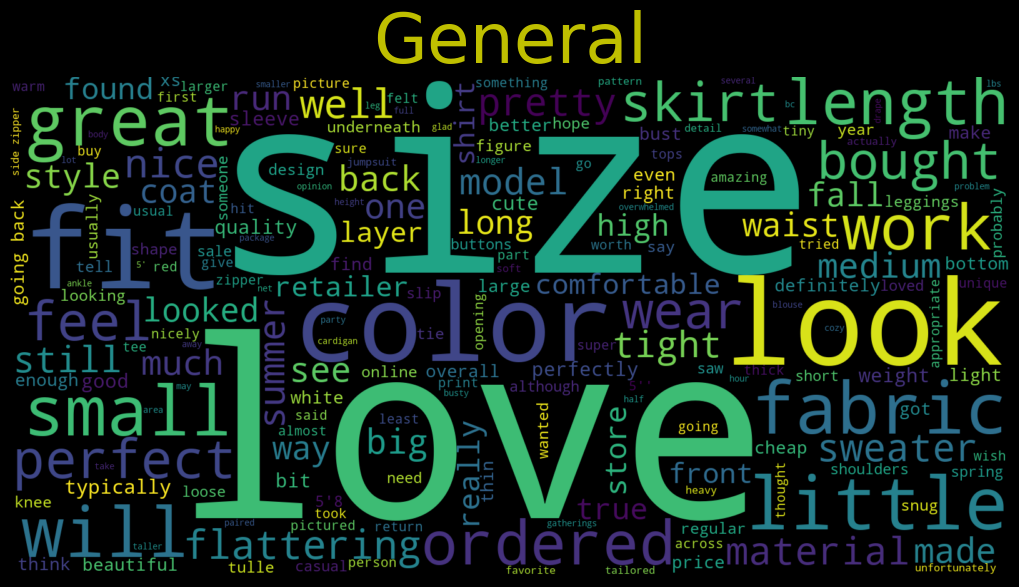

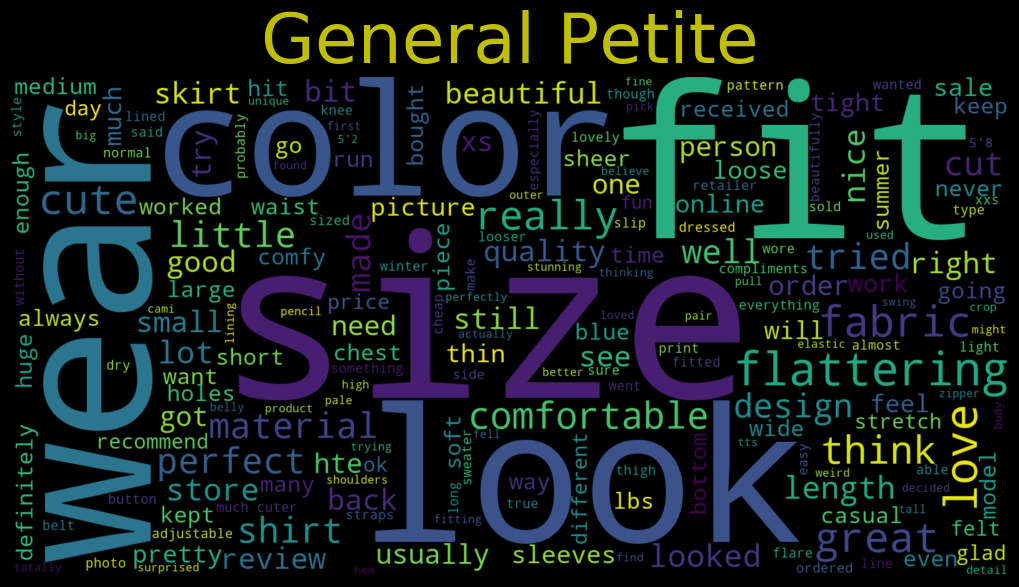

In [63]:
#WordClouds by Department Name 

department_set = df['Department Name'][df['Department Name'].notnull()].unique()
division_set = df['Division Name'][df['Division Name'].notnull()].unique()
def cloud_by_category(data, category, subclass):
    '''
    Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable
    '''
    
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data['Class Name'][data['Class Name'].notnull()].unique())]
                   + [x.lower() for x in list(data['Division Name'][data['Division Name'].notnull()].unique())]
                   + ["dress", "petite", "jacket","top"])
    #Cloud
    cloud(text = data['Review Text'][data[category]==subclass],
         stopwords = new_stop,
         size=(10,6),
         title='{}'.format(subclass))
    
#plot
cloud_by_category(df, "Division Name", division_set[0])
cloud_by_category(df, "Division Name", division_set[1])
cloud_by_category(df, "Division Name", division_set[2])

#### info: 
    For every plot, the most frequent words are fit, size, small and color, 
    one of the explaination, due to the online shopping, can be customers can not try the actual clothes, 
    and thus they have some problems around size and fit.

# N Grams by Recommended Feature

To shade light on the question we find from wordcloud, we use N Grams to check the context and focus on 4 point:

    Fit: Whether the product’s advertised size actually corresponds to customer size and height.
    Love or Hate: The customer's personal feelings towards the product.
    Complements: The customer's social experience wearing the product.
    Product consistency: Whether the product appears as advertised, lives up to quality expectations.

## define function

In [64]:
## Helper Functions
from nltk.util import ngrams
from collections import Counter

def get_ngrams(text, n):
    '''
    return an string list, containing all sequence of words with n words.
    '''
    n_grams=ngrams((text),n)
    #### ngrams就是一個重組器，把text collection中每n個obj串連再一起
    ####ngrams return an ngram obj, an iterator!
    ## next(ngrams((preprocessing(df['Review Text'])),3))
    ####text的格式可為str list, pd.series
    return [' '.join(grams) for grams in n_grams]
    ####利用迭代把iterator 叫出來
## get_ngrams(preprocessing(df['Review Text']),3)

def gramfreq(text,n, num):
    # Extracting bigrams
    result= get_ngrams(text, n)
    
    # Counting bigrams
    result_count=Counter(result)
    #### Counter 會把list 中每個出現過的項目，計算次數，以dict的方式呈現
    ##Counter(get_ngrams(preprocessing(df['Review Text']),2))
    
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df= df.rename(columns={'index':'words', 0:'frequency'})
    return df.sort_values(['frequency'], ascending=False)[:num]
    

def gram_table(data, gram, length):
    out= pd.DataFrame(index=None)
    for i in gram:
        table= pd.DataFrame(gramfreq(preprocessing(data), i, length).reset_index())
        table.columns = ['{}-Gram'.format(i), 'Occurrence']
        out=pd.concat([out, table], axis=1)
    return out

## n-gram by Recommeded int

In [65]:
print('Non-Recommended Items')
gram_table(data=df['Review Text'][df['Recommended IND'].astype(int)==0], gram=[1,2,3,4,5], length=30)

Non-Recommended Items


1-Gram  Occurrence         2-Gram  Occurrence                  3-Gram  \
0      dress        1976    wanted love         243      really wanted love   
1       like        1780     going back         215       wanted love dress   
2        top        1572    looked like         187      really wanted like   
3      would        1348     looks like         153          made look like   
4        fit        1327  really wanted         151         wanted love top   
5     fabric        1245      made look         135           fit true size   
6       size        1209      look like         126      ordered usual size   
7       back        1039            5 4         113         way much fabric   
8       look         965      felt like         109        sadly going back   
9       love         928      true size         104      like maternity top   
10     small         910   usually wear         103       usually wear size   
11         5         871     love dress          95          one going back   
12    really         869    much fabric          89         first time wore   
13   ordered         825            5 5          88         would look good   
14      wear         756       fit well          81     looked like wearing   
15  material         736     size small          80       looks great model   
16      much         721  thought would          80   looked like maternity   
17     color         717            5 7          79      looks nothing like   
18     shirt         687            5 2          79       excited get dress   
19       one         647      well made          76         wanted like top   
20       way         645            5 8          75       felt like wearing   
21      also         643            5 3          73  really looking forward   
22     looks         622  ordered small          71          make look like   
23      even         602     would look          71       would look better   
24    looked         589     runs small          70           reference 5 5   
25   quality         559     runs large          69        high hopes dress   
26      cute         538      arm holes          68     wanted love sweater   
27     large         538    reference 5          67        would fit better   
28     great         530            5 6          66          high hopes top   
29      made         524     usual size          65                 5 4 120   

    Occurrence                          4-Gram  Occurrence  \
0           70        really wanted love dress          15   
1           65       looked like maternity top          10   
2           40        really wanted like dress           9   
3           29          really wanted like top           9   
4           28                     5 4 120 lbs           8   
5           28          really wanted love top           7   
6           25                     5 7 140 lbs           6   
7           25           measurements 38 30 40           6   
8           24        going back really wanted           6   
9           23       would look better someone           5   
10          23        ordered usual size small           5   
11          20          wanted love dress much           5   
12          18        really wanted love shirt           5   
13          16        looks like maternity top           5   
14          16         back really wanted like           5   
15          15                     5 5 122 lbs           4   
16          15         made look like pregnant           4   
17          14         maybe would look better           4   
18          14  really looking forward wearing           4   
19          14                     5 7 115 lbs           4   
20          14                     5 8 140 lbs           4   
21          13       online ordered right away           4   
22          13      like another reviewer said           4   
23          13          going back wanted love           4   
24    

#### info:
    The size fit is really a big issue, we can see most of the words are related to the size fit. 
    The store need to put more effort on helping customers to find out their true size.
    
    "Looked like maternity" is another clear problem.
    We can compare positive reviews on products of these design to find out how to help customers with "look like maternity" problems.
    
    The arm holes design is also an intresting feedback and deserves futher investigation.

In [66]:
print("Recommended Items")
gram_table(data= df['Review Text'][df['Recommended IND'].astype(int)==1], gram=[1,2,3,4,5], length=30)

Recommended Items


1-Gram  Occurrence            2-Gram  Occurrence  \
0         dress        8590         true size        1243   
1          love        8017        love dress         657   
2          size        7561               5 4         621   
3           fit        5995      usually wear         588   
4           top        5846       looks great         574   
5          wear        5678     fit perfectly         553   
6         great        5583         well made         531   
7          like        5368          love top         524   
8             5        4677               5 3         488   
9         color        3887    fits perfectly         480   
10        small        3816               5 5         444   
11        would        3760         love love         417   
12      perfect        3572        usual size         411   
13       fabric        3552               5 2         409   
14       little        3410        size small         408   
15         look        3074               5 7         378   
16   flattering        3065               5 6         377   
17       really        3054  many compliments         362   
18         soft        3041  highly recommend         361   
19      ordered        3025            size 4         340   
20          one        2989        super cute         325   
21         well        2934            size 6         322   
22  comfortable        2885      skinny jeans         319   
23         fits        2685       fabric soft         315   
24       bought        2684         fit great         314   
25         nice        2609        super soft         313   
26          bit        2556  soft comfortable         312   
27         cute        2503               5 8         309   
28    beautiful        2495   absolutely love         307   
29       length        2341         wear size         298   

                        3-Gram  Occurrence                       4-Gram  \
0               fits true size         264  compliments every time wear   
1                fit true size         192             26 waist 36 hips   
2    received many compliments         163              34b 26 waist 36   
3               runs true size         143     looks great skinny jeans   
4               love love love         138   get compliments every time   
5            usually wear size         107                115 lbs 30 dd   
6              every time wear          81         love love love dress   
7           ordered usual size          79          usually wear size 4   
8          small fit perfectly          72                  5 4 120 lbs   
9         got many compliments          70               5 5 135lbs 34c   
10           looks great jeans          69         dress fits true size   
11        small fits perfectly          65                  5 4 125 lbs   
12          usually wear small          64             5 2 currently 33   
13              fit like glove          64            2 currently 33 25   
14             fits like glove          64  compliments first time wore   
15          normally wear size          59                  5 4 135 lbs   
16  would definitely recommend          57                 lbs 30 dd 26   
17                 true size 5          57              30dd 26 5 waist   
18         usually wear medium          56              115 lbs 30dd 26   
19             runs little big          55                  5 3 120 lbs   
20      compliments every time          53       say enough good things   
21            usual size small          53     ordered usual size small   
22        local retailer store          53                   30 dd 26 5   
23               run true size          52           top fits true size   
24            wish came colors          52          usually wear size 6   
25             first time wore          51    usually wear small medium   
26           runs little large          50           3 4 length sleeves   
27     looking fo

#### info:
    Again, the size fit is important. 'Fit like a glove' and 'true size' show that customers give positive feedback because of the size fit.
    Also, the social feedback is important, we can see 'flattering', 'got many compliments' indicate that customers feel good about the product because others feel good about it. These feedback also tell us the feedback is not only personal but social, other customers will read these reviews to make their decision. 
    Finally, there are some actual size matric appear, we can investigate the story behind it.

# Intelligible Supervised Learning
Supervised learning requires features (independent variable) and a label (dependent variable). The Formatting section does just this by creating a tuple with the comment and customer rating label. Currently the independent variable is the entire comment. However, in order to the Naïve Bayes Algorithm to work, each word must be treated as a variable. Instead of utilizing sequential words, the model notes which words are present out of the entire dictionary of words available in the comments corpus. In order to reduce computational intensity, only the top 5000 most common words will be considered, instead of the 9000 unique words in the corpus. The find_features function does just this by checking the presence of words for a piece of text against word_features, a variable created earlier which includes the top 5000 most common words used by customers in this dataset. The Apply Function to Data section applies the find_features function to each individual customer review using a loop, while also retaining each review’s label.

In [67]:
df['tokenized'] = df['Review Text'].astype(str).str.lower() #Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']),axis=1) # Apply tokenize to each row
#### df.apply即表示“對每一row”, 所以此處的row arg就是df, 把df每一row都做一次slice到'tokenized' col, 此時是一str
#### 因為tokenizer只吃str, 所以只能用iter來處理，不能直接braodcast
df['tokenized'] = df['tokenized'].apply(lambda x:[w for w in x if w not in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
#### stemming 表示去字尾
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text

vocab_count = 2000
word_features = list(all_words.keys())[:vocab_count] # 2000 most recurring unique words

print('number of words columns (One Hot Encoding): {}'.format(len(all_words)))

number of words columns (One Hot Encoding): 14034


## Preprocessing

In [68]:
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text
#### return a FreqDist obj, already sorted

vocab_count = 2000
word_features= list(all_words.keys())[:vocab_count] # 2000 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))


Number of words columns (One Hot Encoding): 14034


## Converting Text to a Model-able format: One Hot Encoding

In [69]:
# Tuple 
labtext = list(zip(df.tokenized, (df['Recommended IND'])))
####a=[1,2], b=[3,4], zip(a,b)= [(1,3),(2,4)]

#Function to create model features
# for each review, records which unique words out of the whole text are present
def find_features(document):
    words= set(document) ####變成不重複
    features={}
    for w in word_features:
        features[w]= (w in words) ####此處是一個boolean, 確認該字於此則review出現
        
    return features
####set(labtext[1][0])

# Apply function to data
featuresets = [(find_features(text),LABEL) for text,LABEL in labtext]
len(featuresets)

#Train/ Test
training_set= featuresets[:15000]
testing_set= featuresets[15000:]


#### Naive Bayes 需要的obj:  [dict(key:booleen), booleen]
#### dict是independent, boolean是dependent

## Naive Bayes
    Independent Variable: Word choices in Reviews
    Dependent Variable: Whether or not review was Recommended

In [70]:
#Posterior = prior_occurrence * likelihood / evidence
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Output
print('Classfier accuracy percent:', round((nltk.classify.accuracy(classifier, testing_set))*100, 2))
print(classifier.show_most_informative_features(40))



Classfier accuracy percent: 85.38
Most Informative Features
                   worst = True                0 : 1      =     23.0 : 1.0
                  player = True                0 : 1      =     16.9 : 1.0
                   shame = True                0 : 1      =     13.8 : 1.0
                    dear = True                0 : 1      =     13.8 : 1.0
                   cheap = True                0 : 1      =     12.3 : 1.0
                  cooler = True                1 : 0      =     12.3 : 1.0
                    poor = True                0 : 1      =     12.2 : 1.0
              compliment = True                1 : 0      =     12.0 : 1.0
                   squat = True                0 : 1      =     10.7 : 1.0
                    mess = True                0 : 1      =     10.4 : 1.0
                    whim = True                1 : 0      =      9.5 : 1.0
                    heel = True                1 : 0      =      8.8 : 1.0
                   clown = True         

##### How to Interpret the Table: 
The first column displays the word, the second represents whether the word is not-recommended (0:1), or recommended (1:0). Lastly, the third column shows the ratio of occurrence. Looking at the first column, “worst” is a non-recommended word, whose presence indicates the review is 23 times more likely to be negative than positive. This model’s accuracy is 82%. Naive Bayes’ predictive power is limited compared to other, more complex models, but accuracy is not the goal for this analysis.

##### 解讀
    第一col: independent obj
    第二col: 此word被歸類為何，0:1表示 歸類為dependent=False, 1:0表示 歸類為dependent = True
    第三col: 在第二col的情境下，兩者的比例         
    把第二col和第三col看作一個區塊，比較好理解！


    eg.
    在cheap = True  的前提下
    Recommended IND = 0 : Recommended IND = 1     的比例是    12.3 : 1.0
    在heel = True  的前提下
    Recommended IND = 1 : Recommended IND = 0     的比例是    8.8 : 1.0

## Key Findings

    Product recommendation and Product rating are used for different purposes.

    Recommended is a strong indicator for positive sentiment in the review.
    Rating is more convoluted, where rating around 3 are hopeful reviews with constructive criticism of the product.

In [72]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
#!pip install scikit-plot
import scikitplot as skplt
!pip3 install eli5
import eli5

  Using cached https://files.pythonhosted.org/packages/ee/2b/246db9e1c2d6f38e999daf0c4d5e54f36fbd0b937ffb13a34d32c2139403/eli5-0.8.2-py2.py3-none-any.whl


In [73]:
vect = TfidfVectorizer()
####Vectorizer choose
vect.fit(df['Review Text'])
####Learn vocabulary and idf from training set.
####fit the dataset, Count the occurrence of each word
####Vectorization 使用count 的方式，把一段文字轉換成"某詞有無出現"的boolean vector
####tfidf不只使用count的方式，而是用詞頻的方式，進而避免無意義的重複出現字詞，eg. of, the！
####此處操作後，得到一個TfidfVectorizer 物件
####餵給vectrizer的物件不用tokenized!

####vectorizer 就像是plt的畫布使用方式一樣，要先對物件進行操作，餵數據給它

X= vect.transform(df['Review Text'])
####Transform documents to document-term matrix.


In [ ]:
#print(vect.vocabulary_)
##print out the word presenting count
#print(vect.idf_)
##print out the idf score of each word
#print(X.toarray())
##make the transformed obj as array to be easily read

##### Reference:
   vectorization(詞頻矩陣）:https://medium.com/@paritosh_30025/natural-language-processing-text-data-vectorization-af2520529cf7
   
   tf/idf : https://blog.csdn.net/Eastmount/article/details/50323063
   
   code explaination  :  https://zhuanlan.zhihu.com/p/33779124

In [74]:
y = df['Recommended IND'].copy()
####define the dependent variable
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.2, random_state=23, stratify=y)
## x should be array, y should be list
####記住上面一行已經定義過X（independent）是什麼
####這裡切分train 和 test的方式是分別切分出“train的x,y”和“test的x,y”，所以會有四個物件，和R切成兩個DF不同


In [75]:
from sklearn.linear_model import LogisticRegression
model= LogisticRegression()
model.fit(X_train, y_train)
print('Train Set Accuracy: {}'.format(metrics.accuracy_score(model.predict(X_train),y_train)))
print('Train Set AUC: {}\n'.format(metrics.roc_auc_score(model.predict(X_train),y_train)))

print("Validation Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_valid), y_valid)))
print("Validation Set AUC: {}".format(metrics.roc_auc_score(model.predict(X_valid),y_valid)))

Train Set Accuracy: 0.9114917127071823
Train Set AUC: 0.8877251126816443

Validation Set Accuracy: 0.8941670349094123
Validation Set AUC: 0.8516323584559313


In [76]:
# Report
print(metrics.classification_report(model.predict(X_valid), y_valid))


              precision    recall  f1-score   support

           0       0.56      0.79      0.66       579
           1       0.97      0.91      0.94      3947

    accuracy                           0.89      4526
   macro avg       0.76      0.85      0.80      4526
weighted avg       0.92      0.89      0.90      4526



##### report interpreting explaination:
    Precision = TP/(TP + FP)
    Recall = TP/(TP+FN)
    F1 = 2 * (precision x recall)/(precision + recall)
referrence : https://joshlawman.com/metrics-classification-report-breakdown-precision-recall-f1/

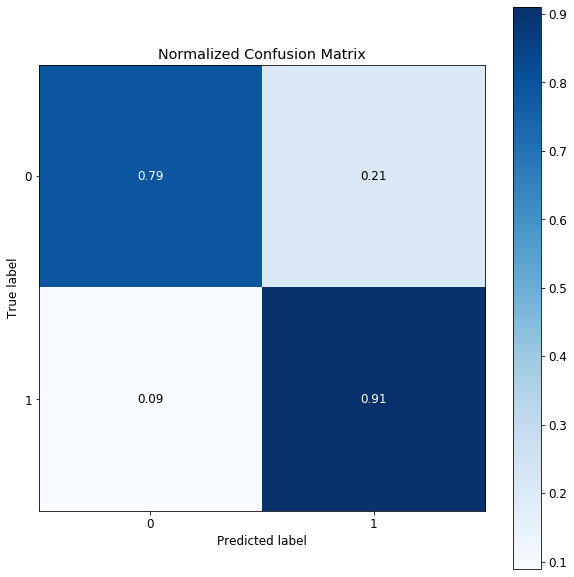

In [77]:
# Confusion Matrix

skplt.metrics.plot_confusion_matrix(model.predict(X_valid), y_valid, normalize= True)
plt.show()

## ELI5 找時間搞懂這裡的vect邏輯！

In [78]:
target_names = ["Not Recommended","Recommended"]
eli5.show_weights(model, vec=vect, top=100, target_names=target_names)
####這裡的model是logit, vect即是把這個model拿去跑哪個data, target_names是y的名字

In [79]:
for i in range(15):
    samp = random.randint(1,df.shape[0])
    print("Real Label: {}".format(df['Recommended IND'].iloc[samp]))
    display(eli5.show_prediction(model,df['Review Text'].iloc[samp], vec=vect, target_names=target_names))
    ####這裡的vec需要是fitted Vectorizer
    

Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 0


Real Label: 0


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


In [6]:
!pip install nbconvert